### 1. Libraries

In [1]:
# Libraries
import datetime as dt
import numpy as np
import pandas as pd
import warnings

In [2]:
# Disable depreciated warnings
pd.set_option("mode.chained_assignment",None)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import ipywidgets as widgets
from sklearn.preprocessing import StandardScaler

In [4]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.pyplot import cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
sns.set()

In [5]:
# Date formats
days_loc = mdates.DayLocator(interval=7)
months_loc = mdates.MonthLocator()
years_loc = mdates.YearLocator()

days_fmt = mdates.DateFormatter("%Y-%m-%d")
months_fmt = mdates.DateFormatter("%Y-%m")
years_fmt = mdates.DateFormatter("%Y")

In [6]:
# Autocorrelation & Stationarity
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
# Custom libraries
import yieldcurves as yc
import principalcomponents as pc
import autoregressive as ar

In [8]:
def rainbow(categories):
    """
    This function generates a dictionary of color codes for each category.
    """
    c_scale = cm.rainbow(np.linspace(0,1,len(categories)))
    c_dict = {}

    for i,c in zip(categories,c_scale):
        c_dict[i] = c
        
    return c_dict

In [9]:
def underline(string):
    chr_start = "\033[4m"
    chr_end = "\033[0m"
    print(chr_start + string + chr_end)

### 2. Parameters

In [12]:
# Choose the maturities that should be used for calculation
maturities = [0.25, 0.5, 1, 2, 3 , 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

# Choose the maturities that should be depicted in charts
maturities_visual = [0.25, 0.5, 2, 5, 10, 14, 20, 26, 30]

In [13]:
# Parameters for data preparation 
widg_start = widgets.DatePicker(description = "Start date", value = dt.date(2005,1,1), disabled = False)
widg_end   = widgets.DatePicker(description = "End date",   value = dt.date(2021,1,1), disabled = False)
widg_freq  = widgets.Dropdown(options = ["day", "week", "month"], 
                              value = "day", 
                              description = "Frequency:",
                              disabled = False)

In [108]:
start_date

'2004-09-06'

In [14]:
# Widget for start date of testing window
widg_test = widgets.DatePicker(description = "Test start", value = dt.date(2018,1,1), disabled = False)

# Widget if time series shall be differenced
widg_diff = widgets.Dropdown(options=[True,False], value=True, description="Differencing:")

# Widget for number of principal components
widg_k = widgets.IntSlider(value=3, min=3, max=20, step=1,
                           description = "# PC:",
                           orientation = "horizontal",
                           readout = True)

# Widget for number of lags in model
widg_lag = widgets.IntSlider(value=5, min=1, max=50, step=1,
                             description="# Lags:",
                             orientation="horizontal",
                             readout=True)

# Widget for number of forecast steps
widg_steps = widgets.IntSlider(value=100, min=1, max=500, step=1,
                               description = "# Steps:",
                               orientation = "horizontal",
                               readout = True)

In [15]:
underline ("Data Parameters:")
display(widg_start)
display(widg_end)
display(widg_freq)

print ("\n")

underline ("Model Parameters")
display (widg_test)
display (widg_diff)
display (widg_k)
display (widg_lag)
display (widg_steps)

Data Parameters:


DatePicker(value=datetime.date(2005, 1, 1), description='Start date')

DatePicker(value=datetime.date(2021, 1, 1), description='End date')

Dropdown(description='Frequency:', options=('day', 'week', 'month'), value='day')



Model Parameters


DatePicker(value=datetime.date(2018, 1, 1), description='Test start')

Dropdown(description='Differencing:', options=(True, False), value=True)

IntSlider(value=3, description='# PC:', max=20, min=3)

IntSlider(value=5, description='# Lags:', max=50, min=1)

IntSlider(value=100, description='# Steps:', max=500, min=1)

In [16]:
# Store data prep parameters
start_date = widg_start.value.strftime("%Y-%m-%d")
end_date   = widg_end.value.strftime("%Y-%m-%d")
frequency  = widg_freq.value

# Store model parameters
test_start = widg_test.value.strftime("%Y-%m-%d")
diff  = widg_diff.value
k     = widg_k.value
lag   = widg_lag.value
steps = widg_steps.value

### 3. Data

#### 3.1 Data Cleaning

In [21]:
# Import euro yield curves
raw_rates = yc.import_rates(filepath = "/Users/neelpatel/Documents/Resume_Projects/PCA_Yield_Curve_Analytics/",
                            filename = "ECB_AAA_Jan2015_Dec2020.csv")

In [23]:
raw_rates.shape

(5072, 3)

In [24]:
raw_rates.head()

DATE  TIME PERIOD  \
0  2004-09-06  06 Sep 2004   
1  2004-09-07  07 Sep 2004   
2  2004-09-08  08 Sep 2004   
3  2004-09-09  09 Sep 2004   
4  2004-09-10  10 Sep 2004   

   Yield curve spot rate, 30-year maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_30Y)  
0                                           4.988680                                                                                                                                  
1                                           4.975495                                                                                                                                  
2                                           4.978894                                                                                                                                  
3                                           4.946545                                                                                                                                  
4                                           4.918530

In [25]:
import dask as dd

In [27]:
df = dd.dataframe.csv("/Users/neelpatel/Documents/Resume_Projects/PCA_Yield_Curve_Analytics/data.csv")

AttributeError: module 'dask' has no attribute 'dataframe'

In [28]:
import dask.dataframe as dd

In [35]:
df = dd.read_csv("/Users/neelpatel/Documents/Resume_Projects/PCA_Yield_Curve_Analytics/data.csv")

In [36]:
df.head(n=-10)

/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:6893: UserWarning: Insufficient elements for `head`. -10 elements requested, only 113614 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


KEY FREQ REF_AREA CURRENCY  \
0          YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR   
1          YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR   
2          YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR   
3          YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR   
4          YC.B.U2.EUR.4F.G_N_A.SV_C_YM.BETA0    B       U2      EUR   
...                                       ...  ...      ...      ...   
113609  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.IF_11Y2M    B       U2      EUR   
113610  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.IF_11Y2M    B       U2      EUR   
113611  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.IF_11Y2M    B       U2      EUR   
113612  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.IF_11Y2M    B       U2      EUR   
113613  YC.B.U2.EUR.4F.G_N_A.SV_C_YM.IF_11Y2M    B       U2      EUR   

       PROVIDER_FM INSTRUMENT_FM PROVIDER_FM_ID DATA_TYPE_FM TIME_PERIOD  \
0               4F         G_N_A        SV_C_YM        BETA0  2004-09-06   
1               4F         G_N_A        SV_C_YM        BETA0  2004-09-07   
2               4F         G_N_A        SV_C_YM        BETA0  2004-09-08   
3               4F         G_N_A        SV_C_YM        BETA0  2004-09-09   
4               4F         G_N_A        SV_C_YM        BETA0  2004-09-10   
...            ...           ...            ...          ...         ...   
113609          4F         G_N_A        SV_C_YM     IF_11Y2M  2023-12-13   
113610          4F         G_N_A        SV_C_YM     IF_11Y2M  2023-12-14   
113611          4F         G_N_A        SV_C_YM     IF_11Y2M  2023-12-15   
113612          4F         G_N_A        SV_C_YM     IF_11Y2M  2023-12-18   
113613          4F         G_N_A        SV_C_YM     IF_11Y2M  2023-12-19   

        OBS_VALUE  ... UNIT_INDEX_BASE COMPILATION  COVERAGE  DECIMALS  \
0        5.410510  ...             NaN         NaN       NaN         6   
1        5.391886  ...             NaN         NaN       NaN         6   
2        5.385978  ...             NaN         NaN       NaN         6   
3        5.377333  ...             NaN         NaN       NaN         6   
4        5.355732  ...             NaN         NaN       NaN         6   
...           ...  ...             ...         ...       ...       ...   
113609   2.712413  ...             NaN         NaN       NaN         6   
113610   2.744350  ...             NaN         NaN       NaN         6   
113611   2.580560  ...             NaN         NaN       NaN         6   
113612   2.659358  ...             NaN         NaN       NaN         6   
113613   2.564360  ...             NaN         NaN       NaN         6   

       SOURCE_AGENCY  SOURCE_PUB  \
0                NaN         NaN   
1                NaN         NaN   
2                NaN         NaN   
3                NaN         NaN   
4                NaN         NaN   
...              ...         ...   
113609           NaN         NaN   
113610           NaN         NaN   
113611           NaN         NaN   
113612           NaN         NaN   
113613           NaN         NaN   

                                                    TITLE  \
0       Yield curve parameters, Beta 0 - Government bo...   
1       Yield curve parameters, Beta 0 - Government bo...   
2       Yield curve parameters, Beta 0 - Government bo...   
3       Yield curve parameters, Beta 0 - Government bo...   
4       Yield curve parameters, Beta 0 - Government bo...   
...                                                   ...   
113609  Yield curve instantaneous forward rate, 11-yea...   
113610  Yield curve instantaneous forward rate, 11-yea...   
113611  Yield curve instantaneous forward rate, 11-yea...   
113612  Yield curve instantaneous forward rate, 11-yea...   
113613  Yield curve instantaneous forward rate, 11-yea...   

                                              TITLE_COMPL       UNIT  \
0       Euro area (changing composition) - Government ...  PURE_NUMB   
1       Euro area (changing composition) - Government ...  PURE_N

In [44]:
# Import euro yield curves
temp1 = yc.import_rates(filepath = "/Users/neelpatel/Documents/Resume_Projects/PCA_Yield_Curve_Analytics/",
                            filename = "data_30Y_3M_Spread.csv")

In [45]:
temp1.head()

DATE        3M        6M        1Y        2Y        3Y        4Y  \
0  2004-09-06  2.034172  2.121920  2.298838  2.641262  2.951578  3.223235   
1  2004-09-07  2.040893  2.138822  2.328891  2.679766  2.987293  3.252486   
2  2004-09-08  2.044384  2.148064  2.346666  2.706542  3.016998  3.282196   
3  2004-09-09  2.037111  2.128935  2.308988  2.646224  2.945649  3.206136   
4  2004-09-10  2.034645  2.111976  2.271566  2.589654  2.884699  3.146724   

         5Y        6Y        7Y  ...       12Y       14Y       16Y       18Y  \
0  3.457222  3.657429  3.828505  ...  4.385283  4.520365  4.626156  4.710629   
1  3.479518  3.673463  3.839294  ...  4.381744  4.514199  4.618160  4.701299   
2  3.507894  3.699959  3.863753  ...  4.397466  4.527387  4.629261  4.710671   
3  3.430628  3.623456  3.789113  ...  4.336578  4.471709  4.578192  4.663603   
4  3.374729  3.571385  3.740559  ...  4.298915  4.436361  4.544571  4.631319   

        20Y       22Y       24Y       26Y       28Y       30Y  
0  4.779293  4.836016  4.883558  4.923925  4.958596  4.988680  
1  4.768947  4.824870  4.871763  4.911590  4.945804  4.975495  
2  4.776881  4.831593  4.877459  4.916408  4.949863  4.978894  
3  4.733254  4.790922  4.839332  4.880479  4.915844  4.946545  
4  4.702037  4.760578  4.809716  4.851478  4.887372  4.918530  

[5 rows x 23 columns]

In [46]:
clean_rates = temp1.copy()

In [47]:
clean_rates.shape

(5074, 23)

In [48]:
clean_rates.set_index('DATE',inplace=True)

In [50]:
clean_rates.head()

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2004-09-06  2.034172  2.121920  2.298838  2.641262  2.951578  3.223235   
2004-09-07  2.040893  2.138822  2.328891  2.679766  2.987293  3.252486   
2004-09-08  2.044384  2.148064  2.346666  2.706542  3.016998  3.282196   
2004-09-09  2.037111  2.128935  2.308988  2.646224  2.945649  3.206136   
2004-09-10  2.034645  2.111976  2.271566  2.589654  2.884699  3.146724   

                  5Y        6Y        7Y        8Y  ...       12Y       14Y  \
DATE                                                ...                       
2004-09-06  3.457222  3.657429  3.828505  3.974939  ...  4.385283  4.520365   
2004-09-07  3.479518  3.673463  3.839294  3.981472  ...  4.381744  4.514199   
2004-09-08  3.507894  3.699959  3.863753  4.003922  ...  4.397466  4.527387   
2004-09-09  3.430628  3.623456  3.789113  3.931745  ...  4.336578  4.471709   
2004-09-10  3.374729  3.571385  3.740559  3.886214  ...  4.298915  4.436361   

                 16Y       18Y       20Y       22Y       24Y       26Y  \
DATE                                                                     
2004-09-06  4.626156  4.710629  4.779293  4.836016  4.883558  4.923925   
2004-09-07  4.618160  4.701299  4.768947  4.824870  4.871763  4.911590   
2004-09-08  4.629261  4.710671  4.776881  4.831593  4.877459  4.916408   
2004-09-09  4.578192  4.663603  4.733254  4.790922  4.839332  4.880479   
2004-09-10  4.544571  4.631319  4.702037  4.760578  4.809716  4.851478   

                 28Y       30Y  
DATE                            
2004-09-06  4.958596  4.988680  
2004-09-07  4.945804  4.975495  
2004-09-08  4.949863  4.978894  
2004-09-09  4.915844  4.946545  
2004-09-10  4.887372  4.918530  

[5 rows x 22 columns]

In [56]:
clean_rates.index = pd.to_datetime(clean_rates.index)

In [57]:
# Transform numeric maturities into string format (%Y%M)
mat_vis = [yc.maturity_transform(i) for i in maturities_visual]
mat_all = [yc.maturity_transform(i) for i in maturities]

# Get list of last available dates per each month
eomonth = clean_rates.loc[clean_rates.groupby(clean_rates.index.to_period("M")).apply(lambda x: x.index.max())].index

# Get list of last available dates per each year
eoyear = clean_rates.loc[clean_rates.groupby(clean_rates.index.to_period("Y")).apply(lambda x: x.index.max())].index

In [79]:
# Train-test split for actual yields; test_start = '2018-01-01'
clean_rates_train = clean_rates[clean_rates.index < test_start]
clean_rates_test  = clean_rates[clean_rates.index >= test_start]

#### 3.2 Visuals

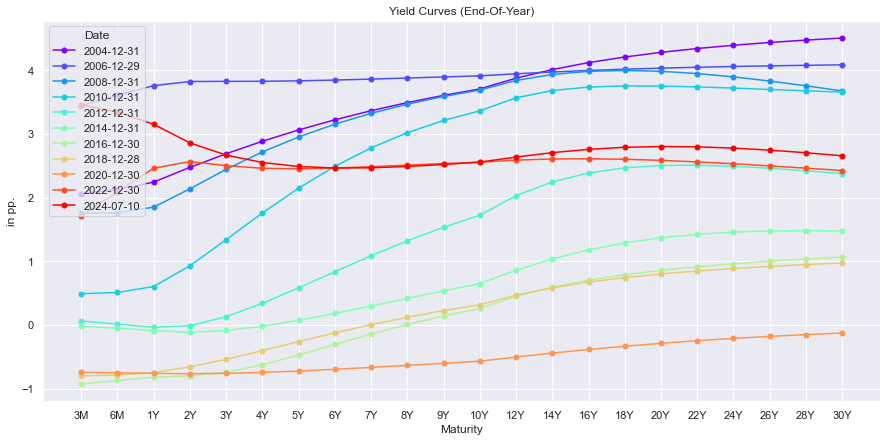

In [81]:
# Depict yield curves per each observed year end
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
color = rainbow(eoyear)

for i,j in enumerate(eoyear):
    if i%2==0: 
        ax.plot(clean_rates.loc[j], marker="o", markersize=5, c=color[j], label=j.date())
    

ax.set_title ("Yield Curves (End-Of-Year)")
ax.set_xlabel ("Maturity")
ax.set_ylabel ("in pp.")
ax.legend(title="Date", loc="upper left")

plt.show()

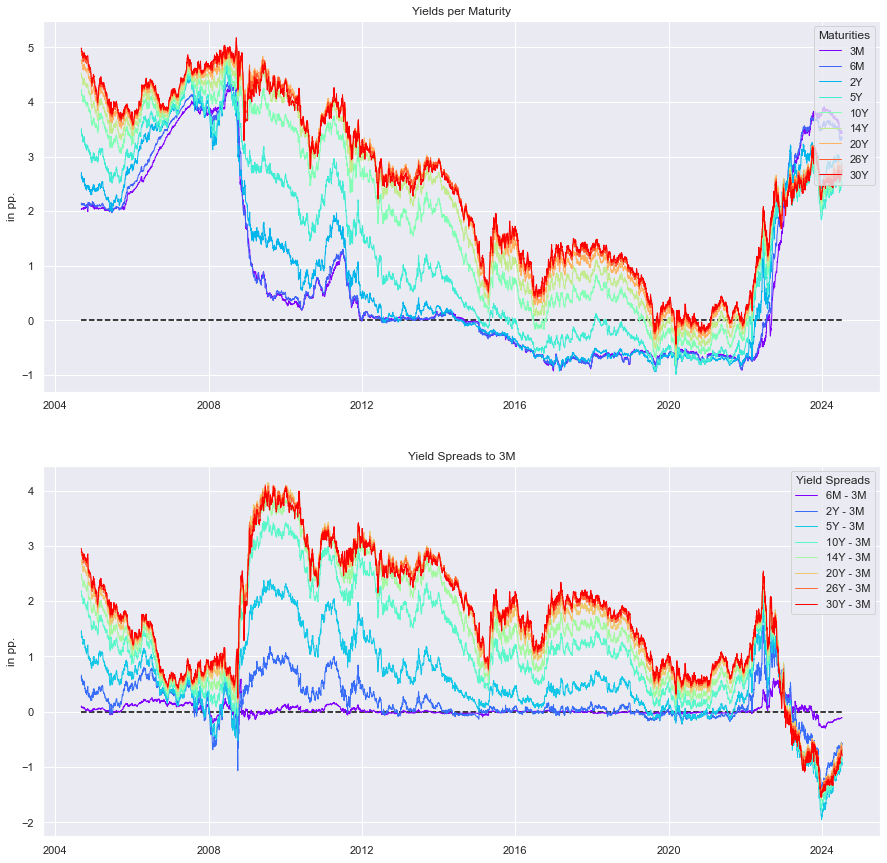

In [84]:
# Depicting yields for various maturities over time
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,15))


# Subplot #1
color = rainbow(mat_vis)
for i in mat_vis: ax1.plot (clean_rates[i], c = color[i], label = i, linewidth=1)

ax1.hlines(y=0, 
           xmin=min(clean_rates.index), 
           xmax=max(clean_rates.index), 
           colors="black", 
           linestyles="dashed")


# Subplot #2
color = rainbow(mat_vis[1:])
for i in mat_vis[1:]: plt.plot (clean_rates[i] - clean_rates.iloc[:,0], c = color[i], label = i+" - 3M", linewidth=1)
     
ax2.hlines(y=0, 
           xmin=min(clean_rates.index), 
           xmax=max(clean_rates.index), 
           colors="black", 
           linestyles="dashed", 
           label="")


# Formatting
ax1.set_title ("Yields per Maturity")
ax1.set_ylabel ("in pp.")
ax1.legend(title = "Maturities", loc = "upper right")

ax2.set_title ("Yield Spreads to 3M")
ax2.set_ylabel ("in pp.")
ax2.legend(title = "Yield Spreads", loc = "upper right")

plt.show()

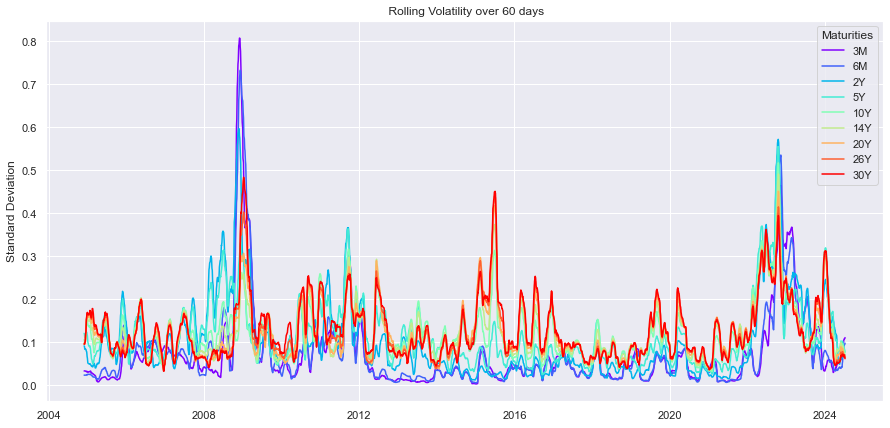

In [87]:
# Insert time window for rolling volatility (in units of previously defined frequency)
roll_window = 60
roll_vola = clean_rates.rolling(roll_window).std().iloc[roll_window-1:]

# Depicting rolling volatility for various maturities over time
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
color = rainbow(mat_vis)

for i in mat_vis:
    ax.plot (roll_vola[i], c = color[i], label = i)

# Formatting
ax.set_title (f' Rolling Volatility over {roll_window} {widg_freq.value}s')
ax.set_ylabel ("Standard Deviation")
ax.legend(title="Maturities", loc="upper right")

plt.show()

#### 3.3 Dynamic

In [88]:
# Notebook backend is necessary to display animated plots
%matplotlib notebook

<IPython.core.display.Javascript object>


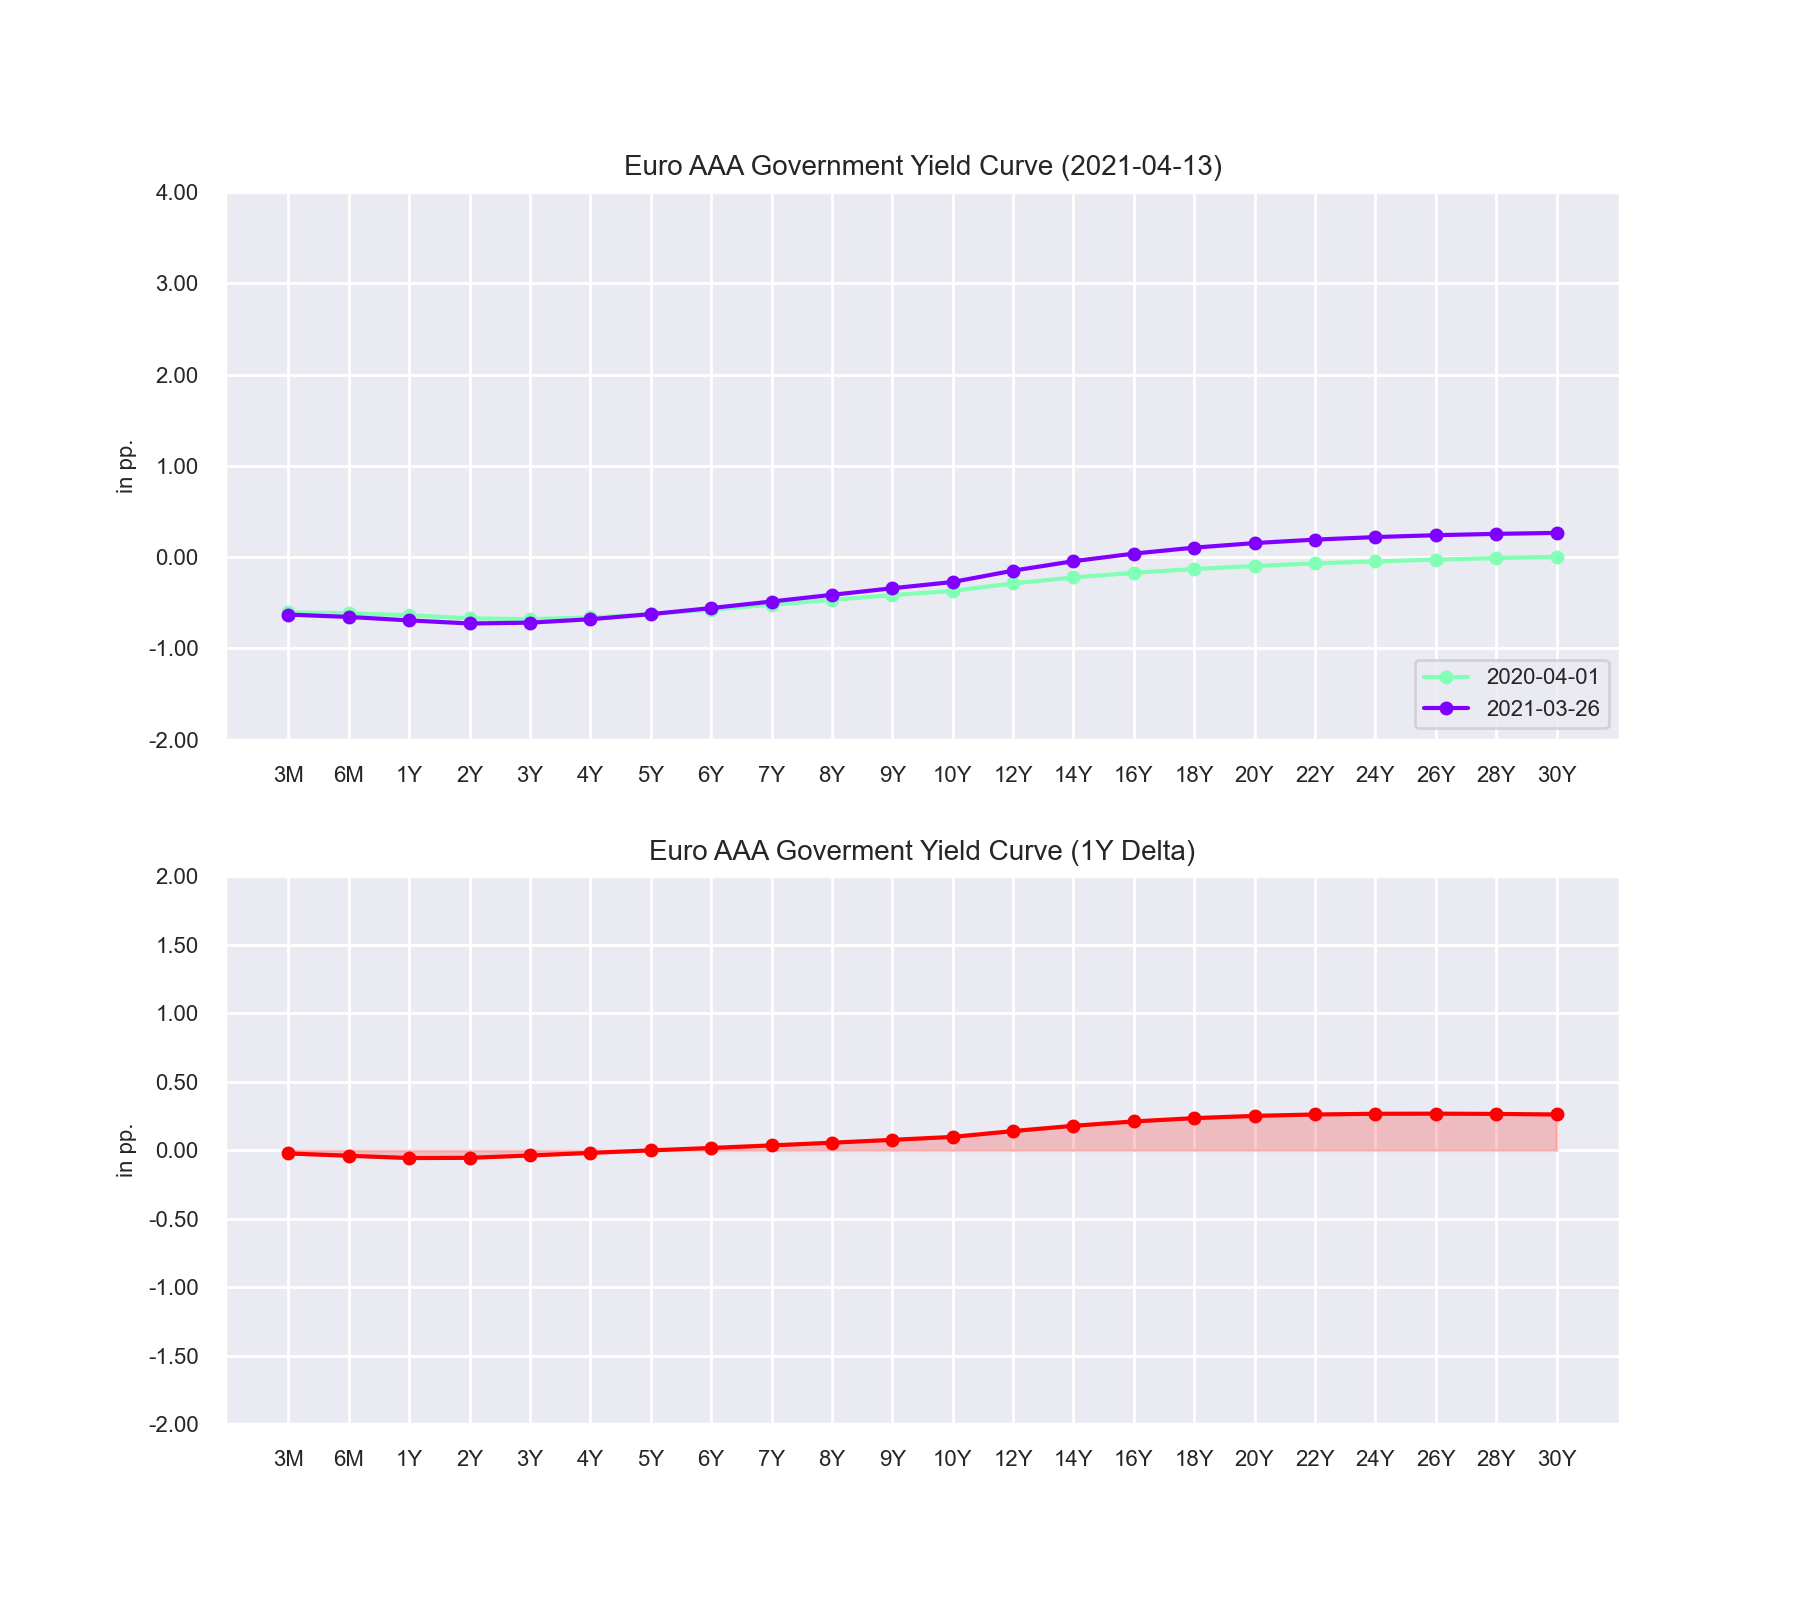

In [111]:
# (1) Creating figure 
fig, (ax1, ax2) = plt.subplots(2, figsize=(9,8))
plt.subplots_adjust(hspace=0.25)
color = rainbow(["yield","lag","delta"])

# (2) Preparing objects
df = clean_rates[2500:].copy()
x = df.iloc[1].index
y = df.iloc[1]

# (3) Initializing objects
yields_lag,   = ax1.plot(x, y, marker='o', markersize=4, c=color["lag"])
yields_now,   = ax1.plot(x, y, marker='o', markersize=4, c=color["yield"])
yields_delta, = ax2.plot(x, y, marker='o', markersize=4, c=color["delta"])

# (4) Fixed formatting
ax1_min = np.floor(df.values.min())
ax1_max = np.ceil(df.values.max())
ax1.set_ylim(ax1_min, ax1_max)

ax1.set_title(start_date)
ax1.set_ylabel("in pp.", fontsize=8)
ax1.tick_params(axis="both", which="major", labelsize=8)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax2.set_ylabel("in pp.", fontsize=8)
ax2.tick_params(axis="both", which="major", labelsize=8)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# (5) Animation function
def animate(i):
    
    # (5.1) Define number of steps delta
    f_dict = {"day":250, "week":52,"month":12}
    f_factor = f_dict[frequency]
    j = max(min(i-1,f_factor),0)

    # (5.2) Updating new data
    yields_now  .set_ydata(df.iloc[i])
    yields_lag  .set_ydata(df.iloc[i-j])
    yields_delta.set_ydata(df.iloc[i] - df.iloc[i-j])
    
    # (5.3) Area chart needs to be cleared and initialized
    ax2.collections.clear()
    ax2.fill_between(x, df.iloc[i] - df.iloc[i-j], 0, color = color["delta"], alpha = 0.2)
    
    # (5.4) Variable formatting
    date_now = df.index[i].strftime("%Y-%m-%d")
    date_lag = df.index[i-j].strftime("%Y-%m-%d")
    
    ax1.legend(loc = "lower right", fontsize = 8)     
    ax1.set_title("Euro AAA Government Yield Curve ("+date_now+")", fontsize = 10)
    ax2.set_title("Euro AAA Goverment Yield Curve (1Y Delta)", fontsize = 10)

    yields_now.set_label(date_now)
    yields_lag.set_label(date_lag)
        
    ax2_min = min(np.floor((df.iloc[i] - df.iloc[i-j]).values.min()),-2)
    ax2_max = max(np.ceil((df.iloc[i] - df.iloc[i-j]).values.max()),2)
    ax2.set_ylim(ax2_min, ax2_max)
 
    
# (6) Animation iterating through the play array
ani = FuncAnimation(fig, animate, np.arange(1,len(df),10), interval=1, blit=True)
plt.show()

In [92]:
ani.save("/Users/neelpatel/Documents/Resume_Projects/PCA_Yield_Curve_Analytics/yields.gif", writer="Pillow")

MovieWriter Pillow unavailable; using Pillow instead.


In [112]:
%matplotlib inline

### 4. Principal Component Analysis

In [113]:
pc_model = pc.PCA(spot = clean_rates, 
                  maturities = mat_all, 
                  k = k)

pc_scores   = pc_model.eig_scores_k
pc_vect     = pc_model.eig_vect_k
pc_vect_inv = pc_model.eig_vect_inv_k
pc_yields   = pc_model.yields
pc_idx      = pc_model.idx[:k]
pc_idx2     = pc_model.idx[:3]

#### 4.1 Eigen Vectors

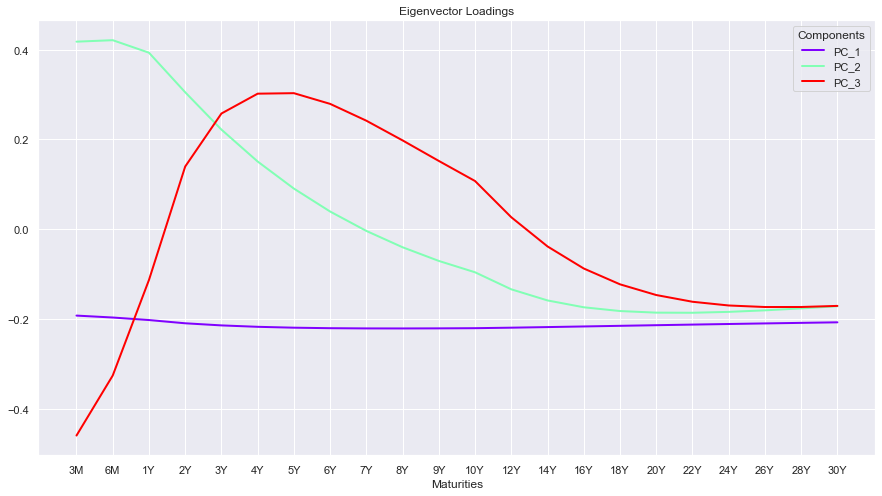

In [124]:
# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
color = cm.rainbow(np.linspace(0,1,3))

for i,c in zip(pc_idx2, color):
    ax.plot(pc_vect[i], c=c, label=i, linewidth=2)

# Formatting
ax.set_title ("Eigenvector Loadings")
ax.set_xlabel ("Maturities")
ax.legend(title="Components")

plt.show()

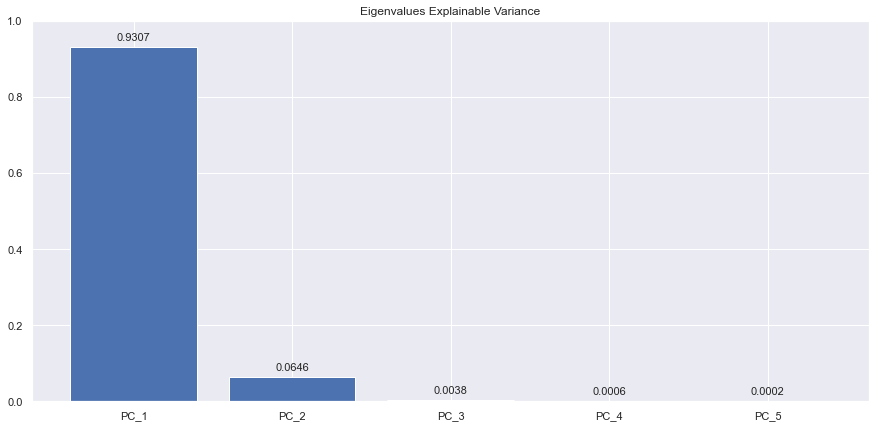

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,7))

# Plotting
ax.bar(pc_model.eig_vals.index[:5], pc_model.eig_vals["eig_val_rel"][:5])
ax.set_ylim(0,1)
ax.set_title ("Eigenvalues Explainable Variance")

# Annotations
for p in ax.patches:
    x_val = p.get_x()
    y_val = p.get_height()
    bar   = p.get_width()/2

    ax.annotate(text = str(round(y_val,4)), 
                xy = (x_val+bar, y_val+0.025), 
                ha = "center", 
                va = "center",
                fontsize = 11)

plt.show()

#### 4.2 Eigen Scores

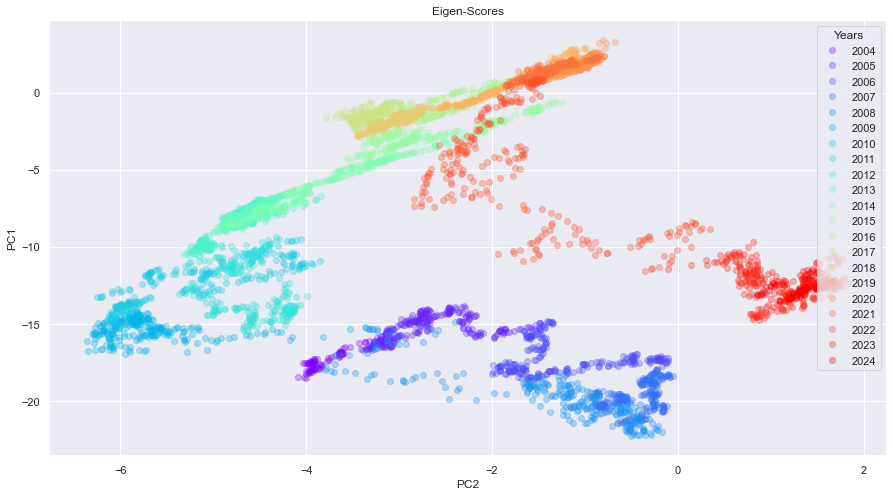

In [132]:
# Define colors
color = rainbow(set(pc_scores.index.year))

# Prepare data for visualization
temp         = pc_scores.copy()
temp["year"] = pc_scores.index.year
temp         = temp.groupby("year")


# Create plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

for label, data in temp:
    ax.plot(data["PC_2"], data["PC_1"], c=color[label], marker="o", linestyle="", alpha=0.3, label=label)


# Formatting
ax.set_title("Eigen-Scores")
ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
plt.legend(title="Years")

plt.show()

#### 4.3 Yield Curve Factors

In [134]:
scaler = StandardScaler()

# Scaled principal components
pc_1 = scaler.fit_transform(pc_scores["PC_1"].values.reshape(-1, 1))*-1
pc_2 = scaler.fit_transform(pc_scores["PC_2"].values.reshape(-1, 1))*-1
pc_3 = scaler.fit_transform(pc_scores["PC_3"].values.reshape(-1, 1))

# Classicla yield curve factors
lvl   = scaler.fit_transform(clean_rates["10Y"].values.reshape(-1, 1))
slope = scaler.fit_transform((clean_rates["10Y"] - clean_rates["6M"]).values.reshape(-1, 1))
curve = scaler.fit_transform((clean_rates["6M"] + clean_rates["10Y"] - 2*clean_rates["5Y"]).values.reshape(-1, 1))

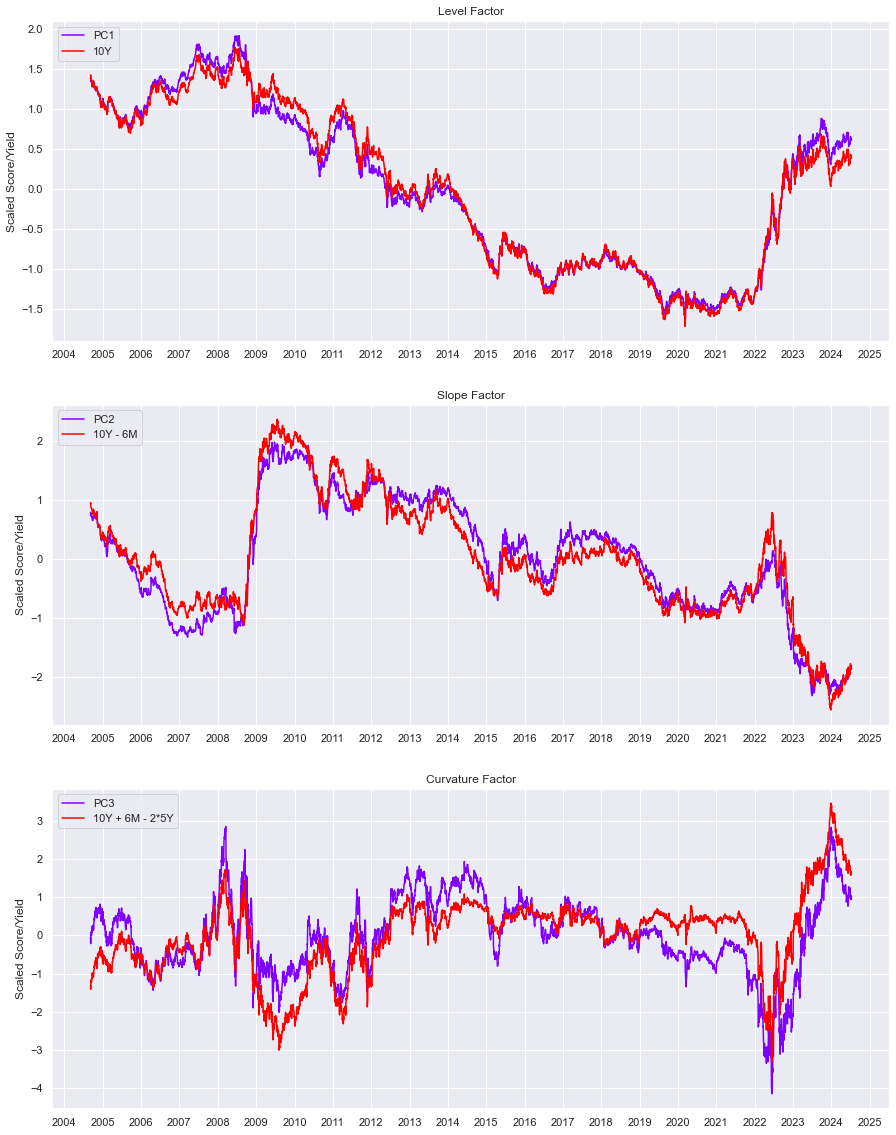

In [135]:
fig, ax = plt.subplots(3, 1, figsize = (15,20))
colors = rainbow(["PC","YC"])

# Create plot
ax[0].plot(pc_scores.index, pc_1, label="PC1", c=colors["PC"])
ax[0].plot(pc_scores.index, lvl,  label="10Y", c=colors["YC"])

ax[1].plot(pc_scores.index, pc_2, label="PC2", c=colors["PC"])
ax[1].plot(pc_scores.index, slope,label="10Y - 6M", c=colors["YC"])

ax[2].plot(pc_scores.index, pc_3*-1, label="PC3", c=colors["PC"])
ax[2].plot(pc_scores.index, curve,label="10Y + 6M - 2*5Y", c=colors["YC"])


# Formatting
ax[0].set_title ("Level Factor")
ax[1].set_title ("Slope Factor")
ax[2].set_title ("Curvature Factor")

for i in range (3):
    ax[i].xaxis.set_major_formatter(years_fmt)
    ax[i].xaxis.set_major_locator(years_loc)
    ax[i].xaxis.set_minor_locator(months_loc)
    
    ax[i].set_ylabel ("Scaled Score/Yield")
    ax[i].legend(loc = "upper left")

plt.show()

#### 4.4 In-Sample Fit

In [136]:
# RMSE 
e = (pc_yields - clean_rates)**2
rmse = pd.Series(data = e.T.mean())**0.5
rmse_year = e.groupby(e.index.year).mean()**0.5

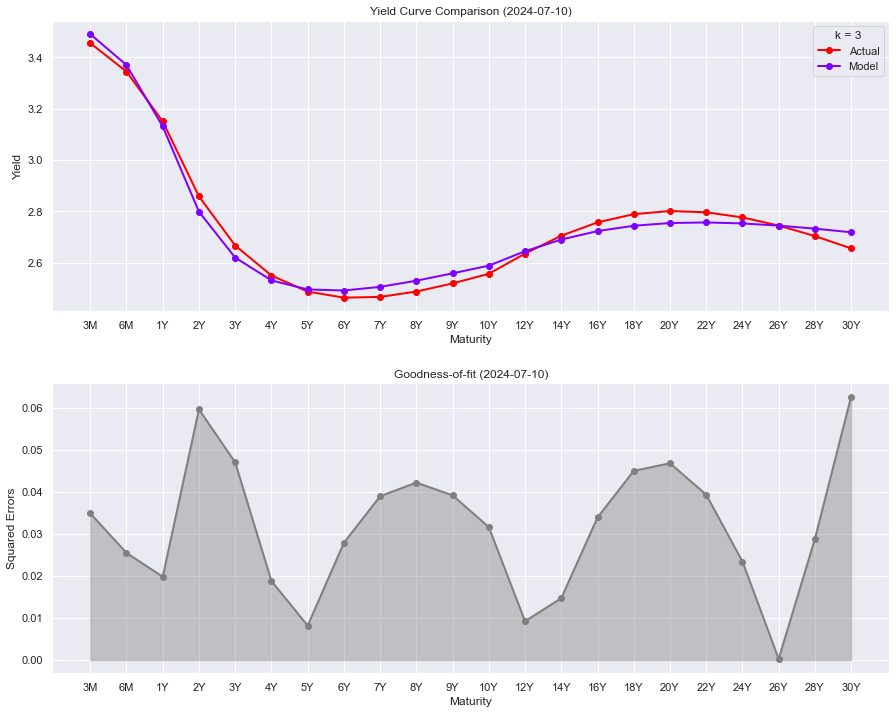

In [137]:
chart_date = eoyear[-1].strftime("%Y-%m-%d")
x = pc_yields.loc[chart_date,:]
y = clean_rates.loc[chart_date,:]
e = np.sqrt((x-y)**2)

# Create plot
fig, ax = plt.subplots(2, 1, figsize = (15,12))

ax[0].plot(y, label="Actual", c=colors["YC"], linewidth=2, marker="o")
ax[0].plot(x, label="Model",  c=colors["PC"], linewidth=2, marker="o")

ax[1].plot(e, c="grey", linewidth=2, marker="o")
ax[1].fill_between(x.index, e, color="grey", alpha=0.4)


# Formatting
ax[0].set_xlabel("Maturity")
ax[0].set_ylabel("Yield")
ax[0].set_title(f"Yield Curve Comparison ({chart_date})")

ax[1].set_xlabel("Maturity")
ax[1].set_ylabel("Squared Errors")
ax[1].set_title(f"Goodness-of-fit ({chart_date})")

ax[0].legend(title = "k = "+str(k))
plt.subplots_adjust(hspace=0.25)
plt.show()

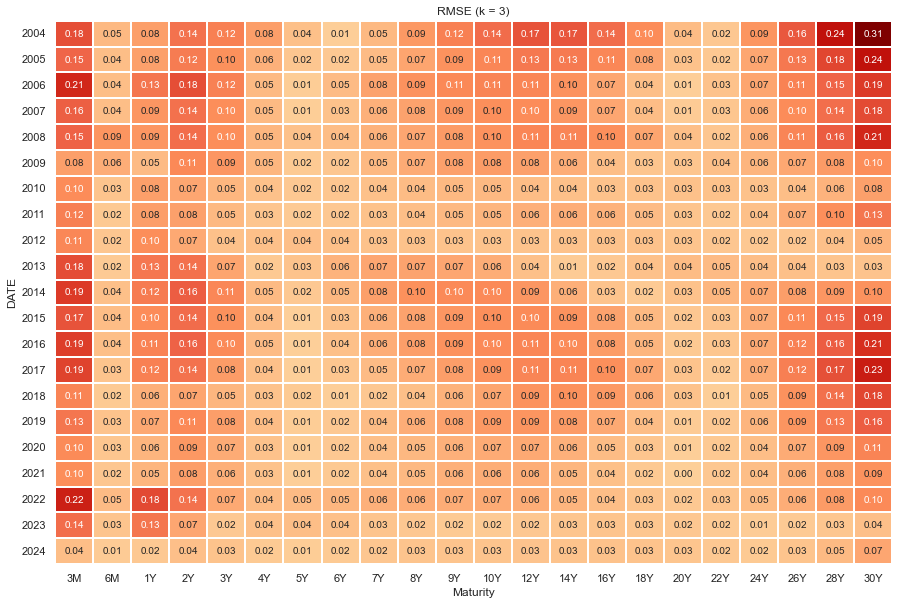

In [140]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(rmse_year, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)


ax.title.set_text("RMSE (k = "+str(k)+")")
ax.set(xlabel="Maturity")

for label in ax.yaxis.get_ticklabels():
    label.set_verticalalignment("center")
    label.set_rotation(0)

plt.show()

#### 4.5 Out-Of-Sample Fit

In [141]:
# Initialize PCA object class
temp = pc.PCA(spot=clean_rates_train, maturities=mat_all, k=k)

# Use out-of-sample function to derive model test yields fitting on eigen-vectors from train-set
pc_yields_oos = temp.pca_oos(eig_vect_train = temp.eig_vect, spot_test = clean_rates_test)
pc_yields_oos.iloc[:5,:10]

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2018-01-02 -0.511809 -0.648912 -0.796311 -0.785582 -0.614219 -0.399900   
2018-01-03 -0.476236 -0.615618 -0.771082 -0.775851 -0.615770 -0.409433   
2018-01-04 -0.459505 -0.596581 -0.749027 -0.752161 -0.593186 -0.388992   
2018-01-05 -0.451075 -0.590210 -0.747189 -0.756684 -0.601038 -0.398448   
2018-01-08 -0.440509 -0.582408 -0.745886 -0.765185 -0.615192 -0.415728   

                  5Y        6Y        7Y        8Y  
DATE                                                
2018-01-02 -0.181668  0.026129  0.217733  0.390753  
2018-01-03 -0.196828  0.007036  0.195937  0.367155  
2018-01-04 -0.178902  0.022373  0.208762  0.377629  
2018-01-05 -0.188946  0.012368  0.199182  0.368697  
2018-01-08 -0.207786 -0.007031  0.179867  0.349871

In [142]:
# RMSE 
e_oos = (pc_yields_oos - clean_rates_test)**2
rmse_oos = pd.Series(data = e_oos.T.mean())**0.5
rmse_oos[0] = rmse[rmse_oos.index[0]]

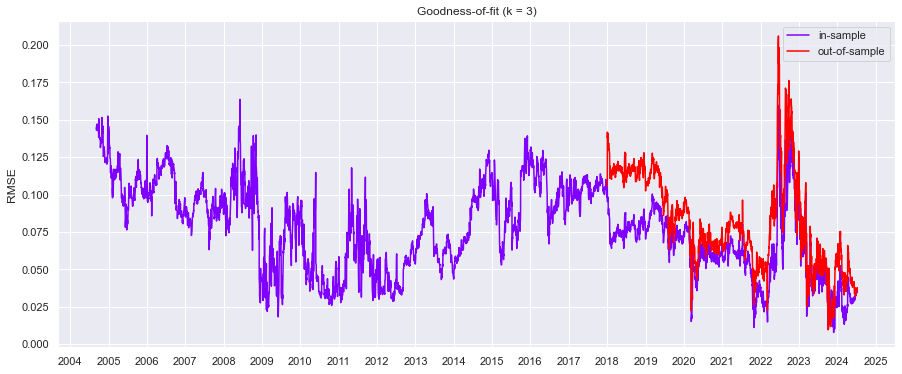

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
color = rainbow(["in-sample","out-of-sample"])

# Plots
ax.plot (rmse, c=color["in-sample"], label="in-sample")
ax.plot (rmse_oos, c=color["out-of-sample"], label="out-of-sample")

# Formatting
ax.set_title ("Goodness-of-fit (k = "+ str(k) + ")")
ax.set_ylabel ("RMSE")
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years_loc)
ax.xaxis.set_minor_locator(months_loc)
ax.legend()

plt.show()

#### 4.6 Dynamic

In [151]:
%matplotlib notebook

<IPython.core.display.Javascript object>


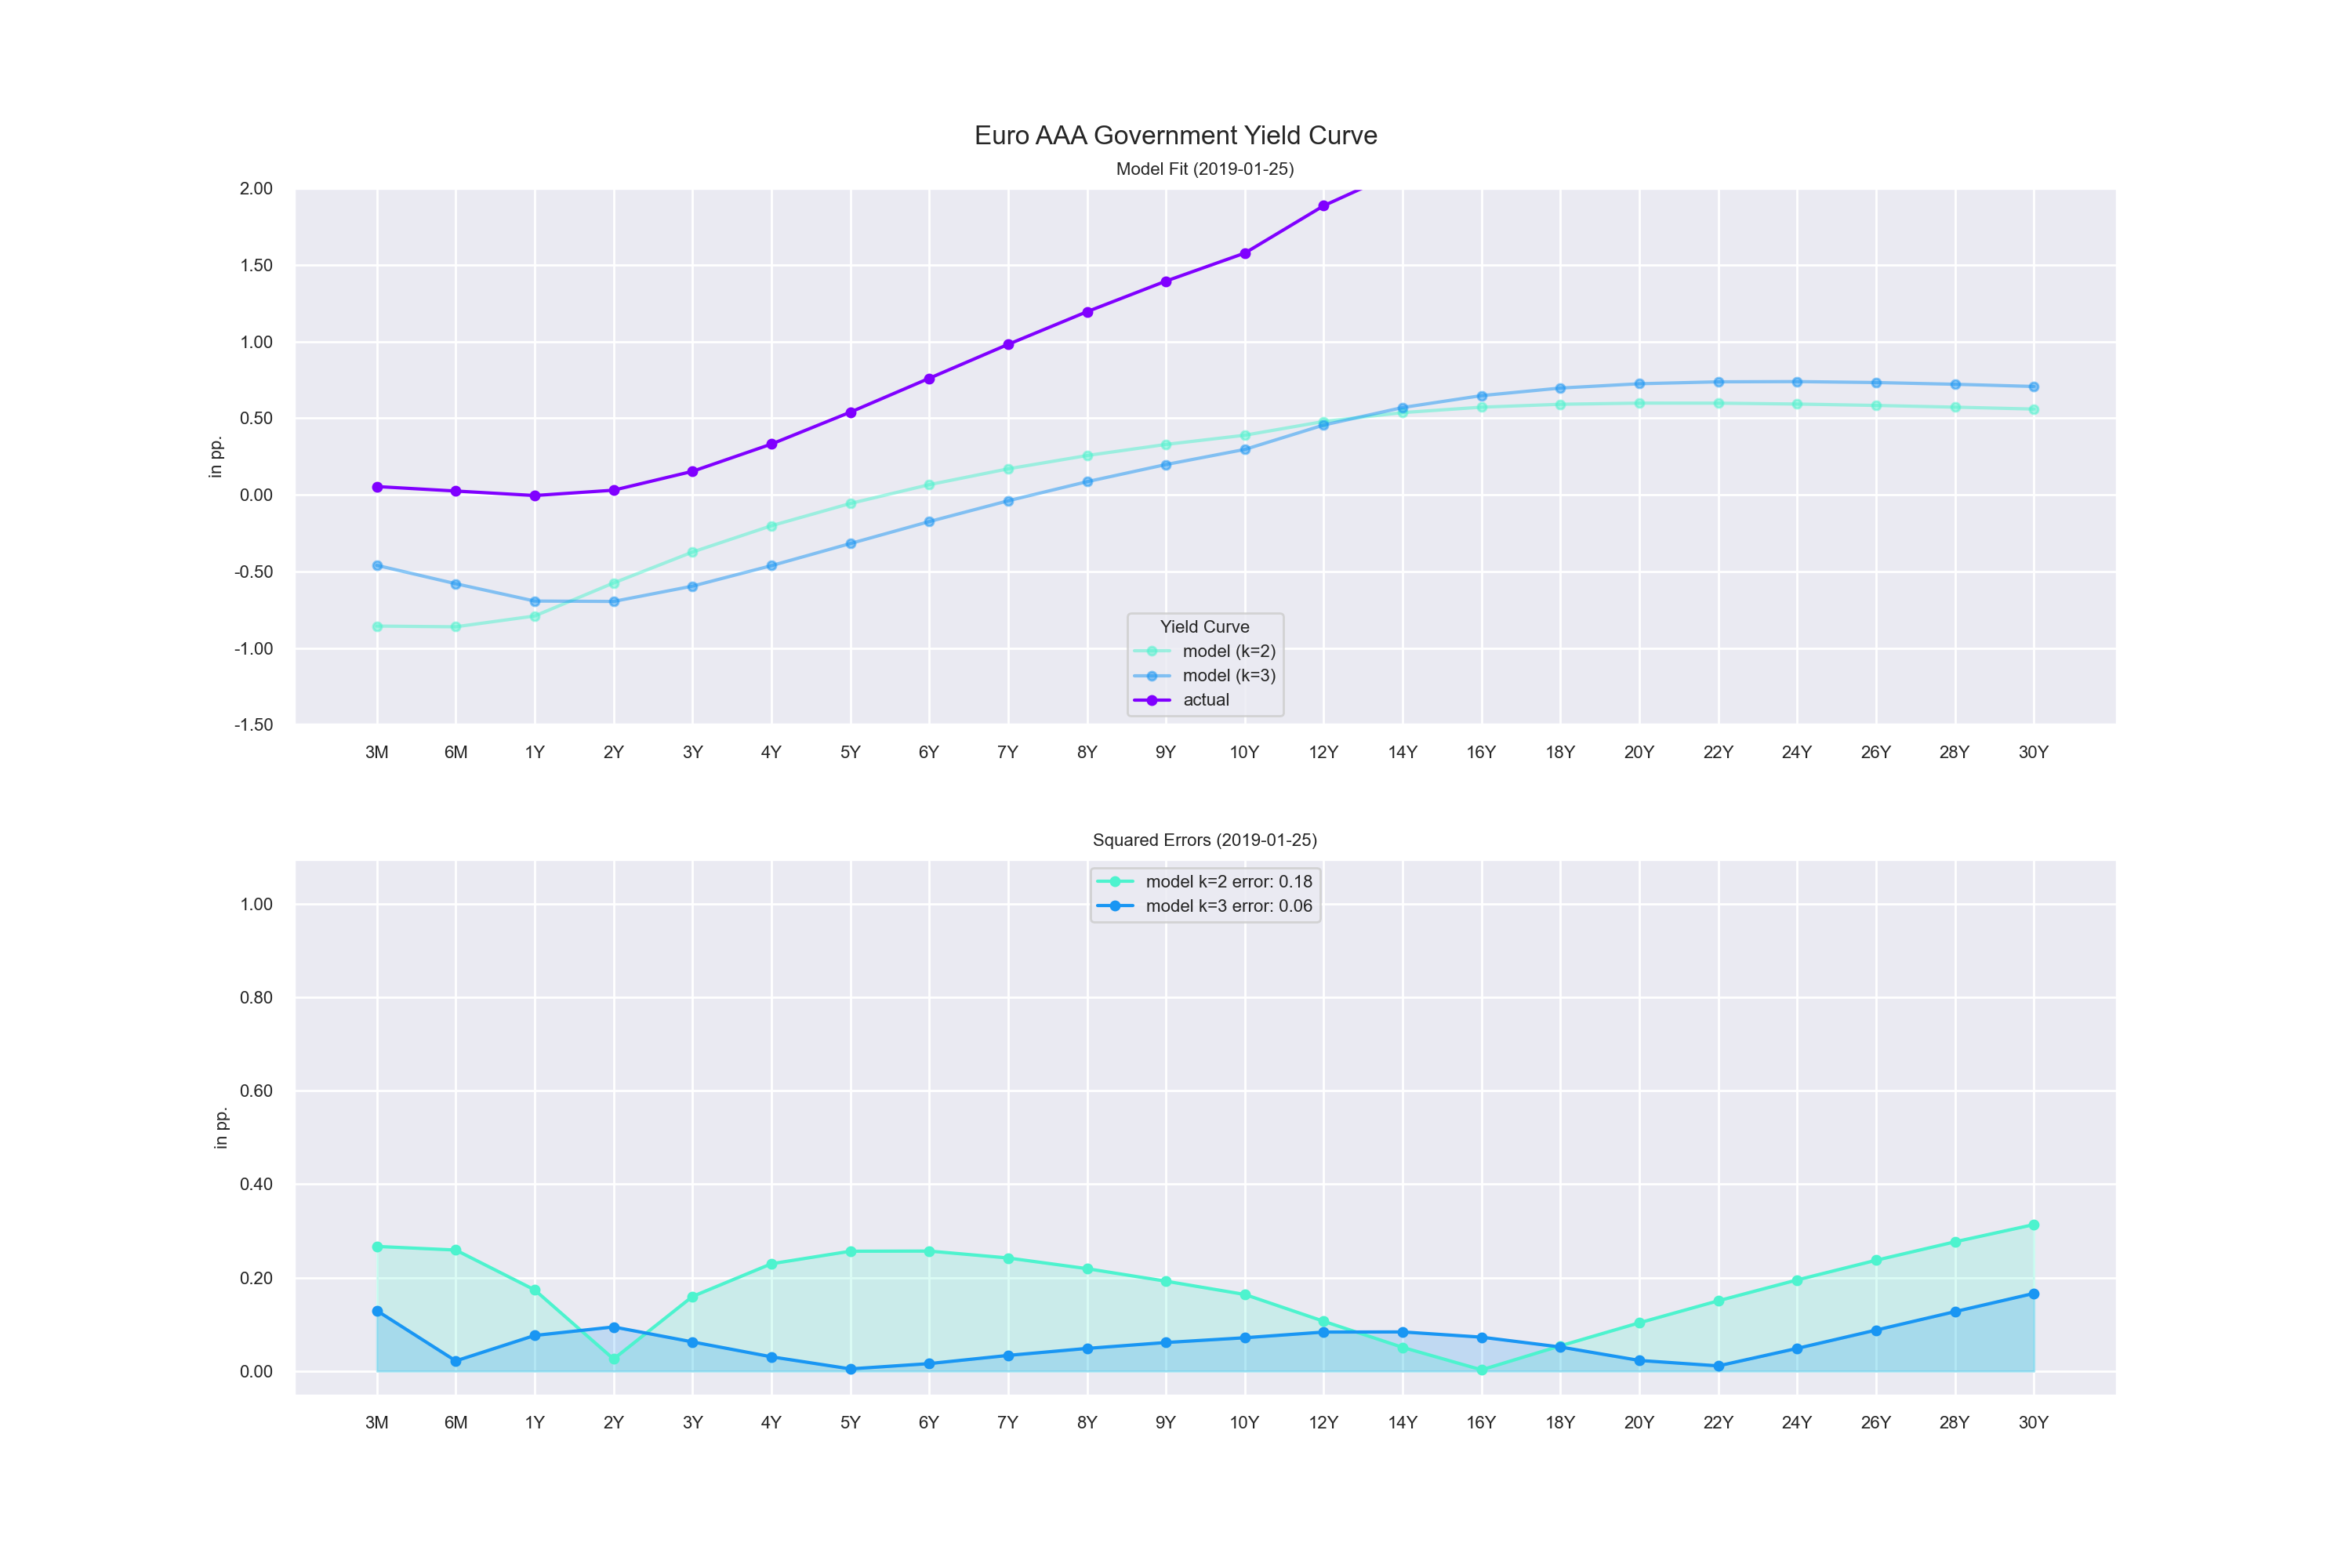

In [152]:
# (1) Creating figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))
fig.suptitle("Euro AAA Government Yield Curve", y=0.92)
plt.subplots_adjust(hspace = 0.25)
color = rainbow(["actual","error_3","error_2","-","-","-"])


# (2) Prepare objects
y1 = clean_rates[2800:].copy()
y2 = pc.PCA(spot = clean_rates, maturities = mat_all, k = 2).yields[2800:]
y3 = pc.PCA(spot = clean_rates, maturities = mat_all, k = 3).yields[2800:]
e2 = np.sqrt((y1-y2)**2)
e3 = np.sqrt((y1-y3)**2)
x  = y1.columns


# (3) Initialize objects
yc_model_2, = ax1.plot(x, y2.iloc[0,:], '-o', markersize=4, c=color["error_2"], label="model (k=2)", alpha=0.5)
yc_model_3, = ax1.plot(x, y3.iloc[0,:], '-o', markersize=4, c=color["error_3"], label="model (k=3)", alpha=0.5)
yc_actual,  = ax1.plot(x, y1.iloc[0,:], '-o', markersize=4, c=color["actual"], label="actual")

yc_error_2, = ax2.plot(x, e2.iloc[0,:], '-o', markersize=4, c=color["error_2"], label="rmse")
yc_error_3, = ax2.plot(x, e3.iloc[0,:], '-o', markersize=4, c=color["error_3"], label="rmse")


# (4) Fixed formatting
ax1.set_title("Evaluation of Fit", fontsize = 10)           # Title
ax1.set_ylabel("in pp.", fontsize=8)                        # Axis label title
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))   # Axis number formatting
ax1.tick_params(axis="both", which="major", labelsize=8)    # Axis ticks

ax1_min = np.floor(y1.values.min())                         # Axis minimum
ax1_max = np.ceil(y1.values.max())                          # Axis maximum
ax1.set_ylim(ax1_min, ax1_max)                              # Axis threshold

ax2.set_title("RMSE of Fit", fontsize = 10)                 # Title
ax2.set_ylabel("in pp.", fontsize=8)                        # Axis label title
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))   # Axis number formatting
ax2.tick_params(axis="both", which="major", labelsize=8)    # Axis ticks


# (5) Animation function
def animate(i):

    # (5.1) Adding new data
    yc_actual .set_ydata(y1.iloc[i,:])
    yc_model_2.set_ydata(y2.iloc[i,:])
    yc_model_3.set_ydata(y3.iloc[i,:])
    yc_error_2.set_ydata(e2.iloc[i,:])
    yc_error_3.set_ydata(e3.iloc[i,:])
    
    # (5.2) Area chart needs to be cleared and initialized
    ax2.collections.clear()
    ax2.fill_between(x, e2.iloc[i,:], 0, color = color["error_2"], alpha = 0.2)
    ax2.fill_between(x, e3.iloc[i,:], 0, color = color["error_3"], alpha = 0.2)
    
    # (5.3) Variable formatting
    date = y1.index[i].strftime("%Y-%m-%d")
    
    ax1.legend(loc = "lower center", fontsize = 8, title = "Yield Curve", title_fontsize = 8)
    ax1.set_title("Model Fit ("+date+")", fontsize = 8)
    
    ax2.legend(loc = "upper center", fontsize = 8)
    ax2.set_title("Squared Errors ("+date+")", fontsize = 8)
    
    # Variable y-axis
    ax1_min = np.floor(y1.iloc[i,:].min())-0.5
    ax1_max = np.ceil(y1.iloc[i,:].max())+0.5
    ax1.set_ylim(-1.5, 2)
    
    # Update legend with RMSE
    rmse_2 = round(np.sqrt((e2.iloc[i,:]**2)).mean(),2)
    rmse_3 = round(np.sqrt((e3.iloc[i,:]**2)).mean(),2)
    yc_error_2.set_label("model k=2 error: "+str(rmse_2))
    yc_error_3.set_label("model k=3 error: "+str(rmse_3))

    
# (6) Animation iterating through the steps array
ani = FuncAnimation(fig, animate, np.arange(1,len(y1),10), interval=1, blit=True)
plt.show()

In [156]:
%matplotlib inline

In [231]:
start_date

'2004-09-06'

In [153]:
ani.save("/Users/neelpatel/Documents/Resume_Projects/PCA_Yield_Curve_Analytics/pc-fit-dyn.gif", writer="Pillow")

MovieWriter Pillow unavailable; using Pillow instead.


In [158]:
%matplotlib notebook

<IPython.core.display.Javascript object>


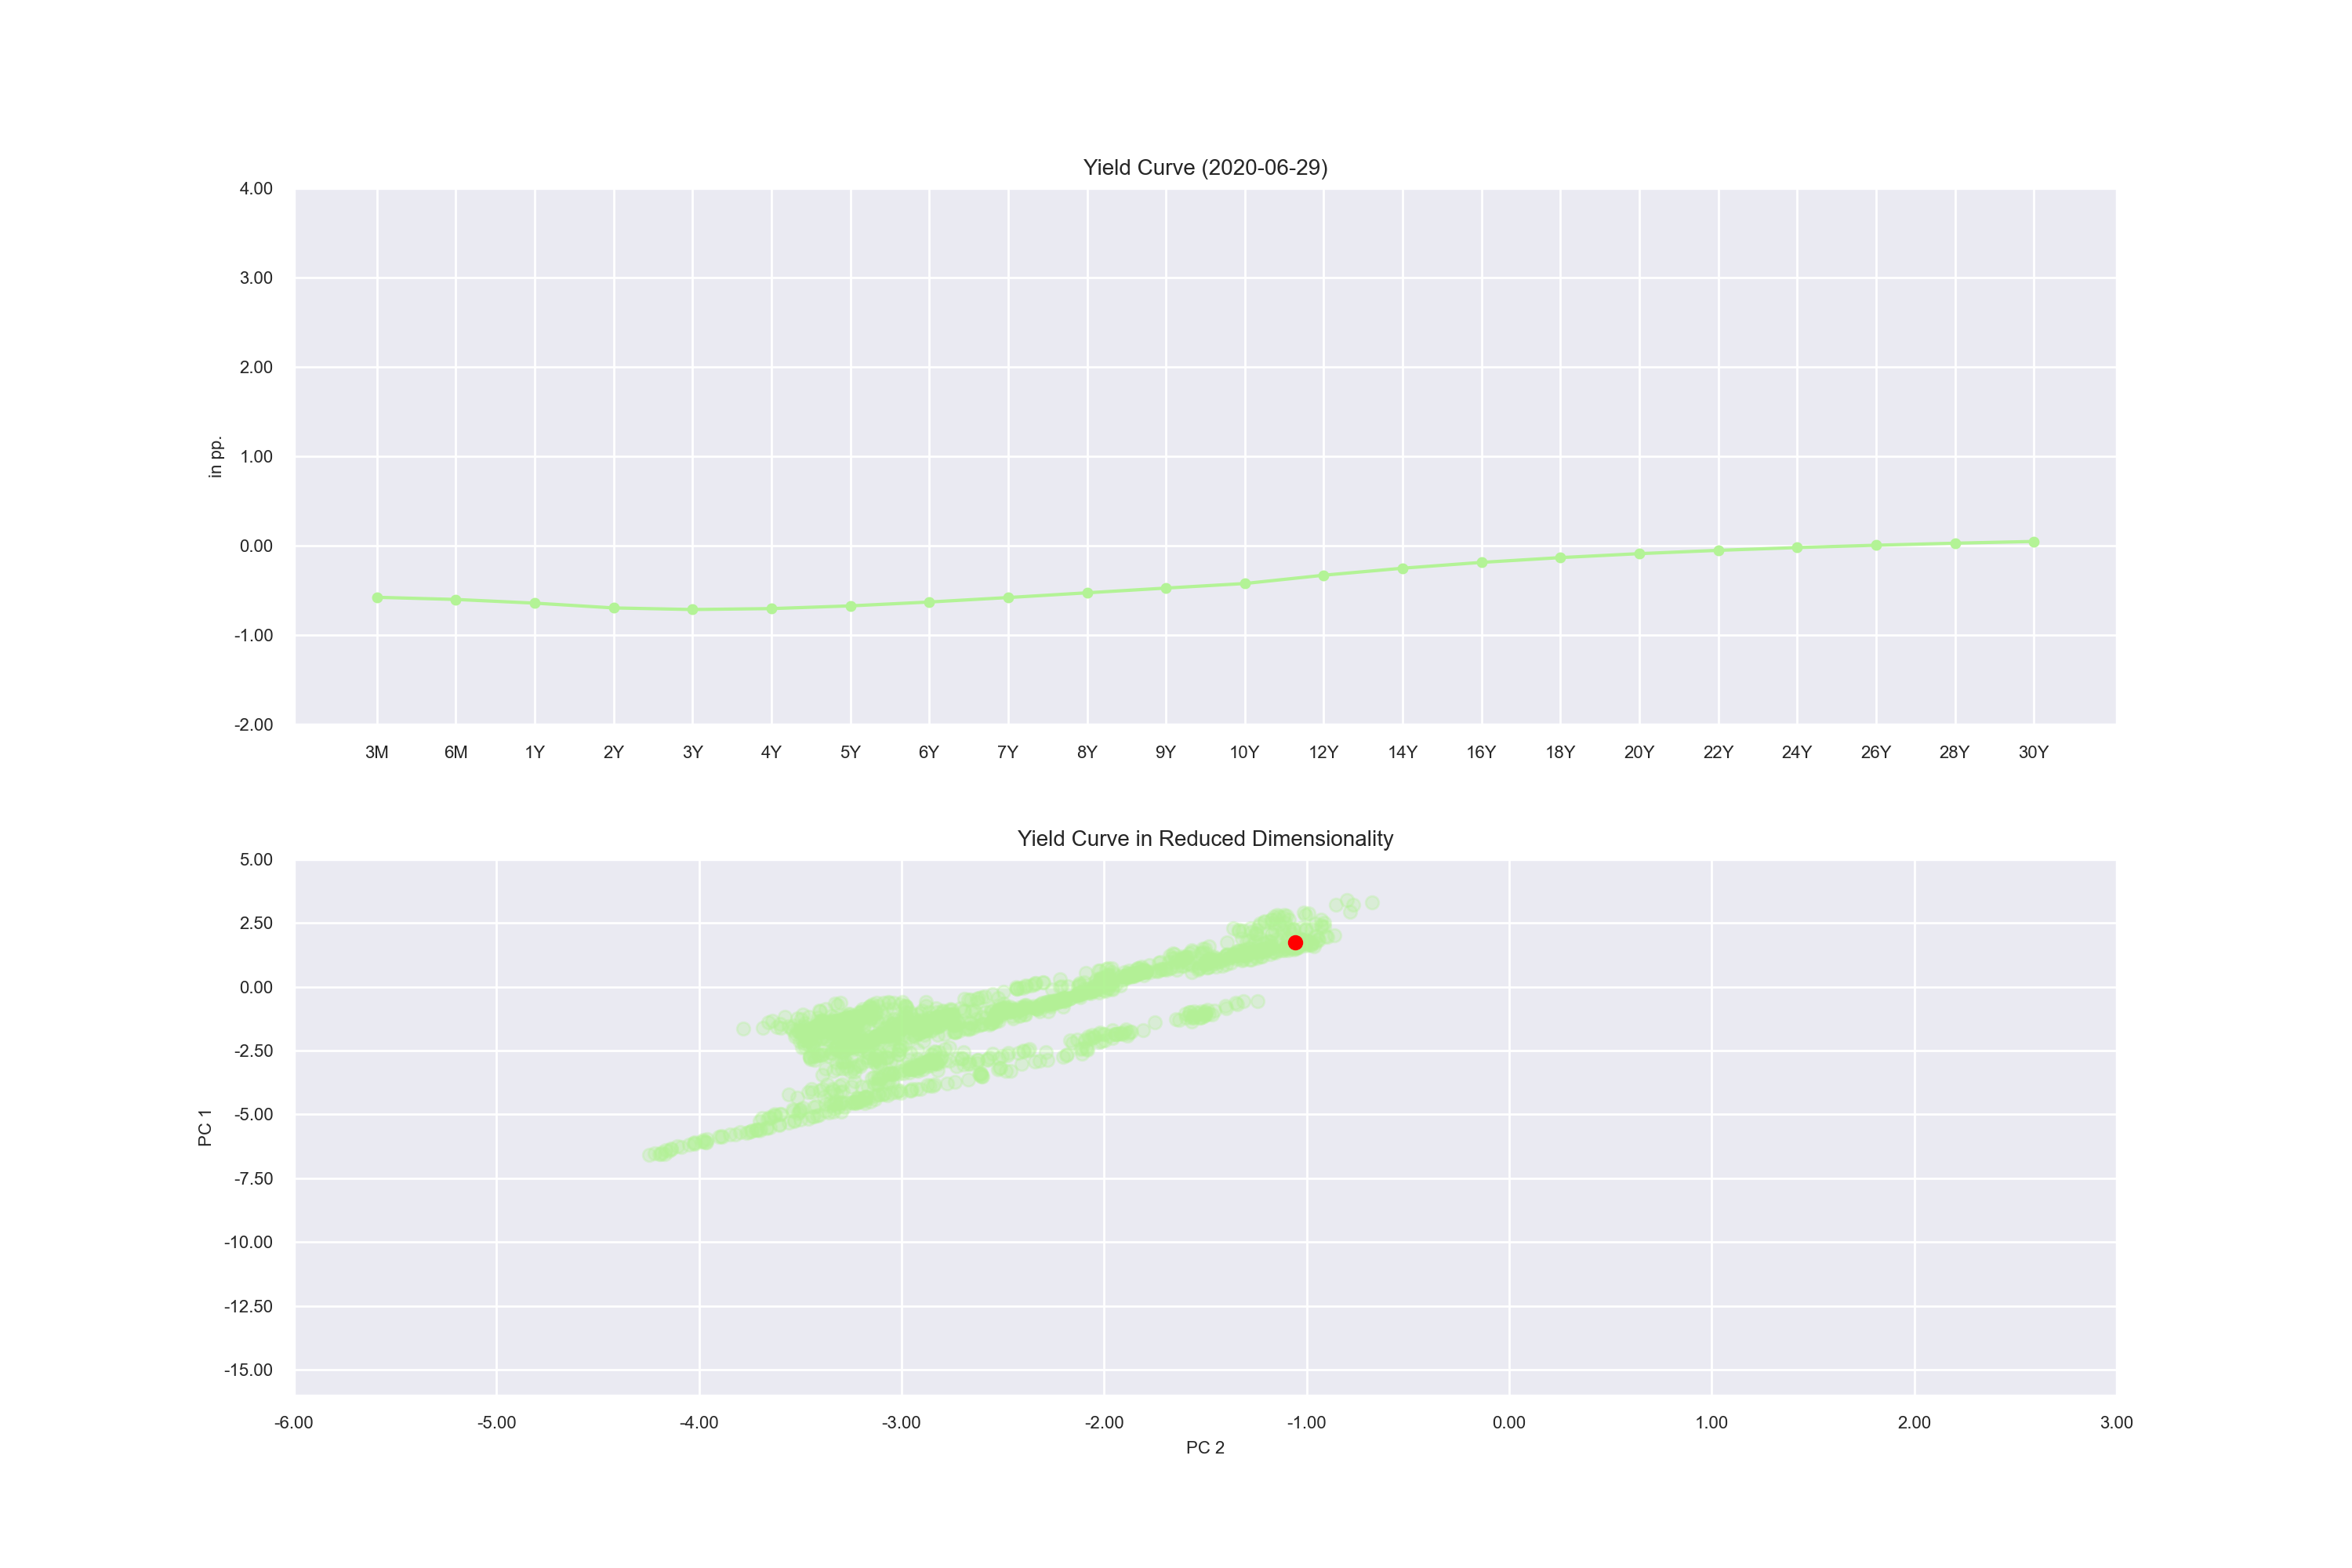

In [159]:
# (1) Creating figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))
plt.subplots_adjust(hspace = 0.25)


# (2) Prepare objects
y1 = clean_rates[2500:].copy()
x1 = y1.columns
y2 = pc_scores["PC_1"][2500:]
x2 = pc_scores["PC_2"][2500:]
color = rainbow(np.arange(len(y2)))


# (3) Initialize objects
chart_yield,  = ax1.plot(x1, y1.iloc[0,:],         marker="o", markersize=4, c=color[0], label="actual")
chart_pc_run, = ax2.plot(x2[0], y2[0], c=color[0], marker="o", linestyle="", alpha = 0.3)
chart_pc_new, = ax2.plot(x2[0], y2[0], c="red",    marker="o", linestyle="")


# (4) Fixed formatting - Subplot #1
ax1.set_title("Yield Curve", fontsize = 10)                              # Title
ax1.set_ylabel("in pp.", fontsize=8)                                     # Axis label title
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))                # Axis number formatting
ax1.tick_params(axis="both", which="major", labelsize=8)                 # Axis ticks

ax1_min = np.floor(y1.values.min())                                      # Axis minimum
ax1_max = np.ceil(y1.values.max())                                       # Axis maximum
ax1.set_ylim(ax1_min, ax1_max)                                           # Axis threshold


# (4) Fixed formatting - Subplot #2
ax2.set_title("Yield Curve in Reduced Dimensionality", fontsize=10)      # Title
ax2.set_ylabel("PC 1", fontsize=8)                                       # Axis label title
ax2.set_xlabel("PC 2", fontsize=8)                                       # Axis label title

ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))                # Axis number formatting
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))                # Axis number formatting
ax2.tick_params(axis="both", which="major", labelsize=8)                 # Axis ticks

ax2.set_xlim(np.floor(x2.min())-1, np.ceil(x2.max())+1)
ax2.set_ylim(np.floor(y2.min())-1, np.ceil(y2.max())+1)  


# (5) Animation function
def animate(i):

    # (5.1) Adding new data
    chart_yield.set_ydata(y1.iloc[i,:])
    chart_yield.set_color(color[i])
    
    chart_pc_run.set_data(x2[:i], y2[:i])
    chart_pc_run.set_color(color[i])
    
    chart_pc_new.set_data(x2[i], y2[i])
    
    # (5.2) Variable formatting
    date = y1.index[i].strftime("%Y-%m-%d")
    ax1.set_title("Yield Curve ("+date+")", fontsize = 10)

    
# (6) Animation iterating through the steps array
ani = FuncAnimation(fig, animate, np.arange(1,len(y1),10), interval=1, blit=True)
plt.show()

In [160]:
ani.save("/Users/neelpatel/Documents/Resume_Projects/PCA_Yield_Curve_Analytics/pc-scores-dyn.gif", writer="Pillow")

MovieWriter Pillow unavailable; using Pillow instead.


In [161]:
%matplotlib inline

### 5. Stationarity Analysis

In [163]:
def adf_test(df, col, alpha):
    """
    This function applies the ADF-test for a respective time series at a certain confidence interval
    Required parameters:
    - df:         DataFrame -> Data under rewiew
    - cols:       List -> List of columns to apply ADF on
    - confidence: Str -> ["1%","5%","10%"]
    """
    model  = adfuller(df[col])
    result = dict()
    
    result["adf_stat"]  = round(model[0],4)
    result["p_val"]     = round(model[1],4)
    result["threshold"] = round(model[4][alpha],4)
    
    if result["adf_stat"] < result["threshold"]:
        result["stationary"] = "yes"
    else:
        result["stationary"] = "no"
    
    return result

In [164]:
for i in pc_idx[:min(3,k)]:
    underline (f'Stationarity-Test: {i}')
    print (adf_test(df = pc_scores, col = i, alpha = "5%"))

Stationarity-Test: PC_1
{'adf_stat': -1.2747, 'p_val': 0.6407, 'threshold': -2.8621, 'stationary': 'no'}
Stationarity-Test: PC_2
{'adf_stat': -1.0003, 'p_val': 0.7532, 'threshold': -2.8621, 'stationary': 'no'}
Stationarity-Test: PC_3
{'adf_stat': -3.2529, 'p_val': 0.0171, 'threshold': -2.8621, 'stationary': 'yes'}


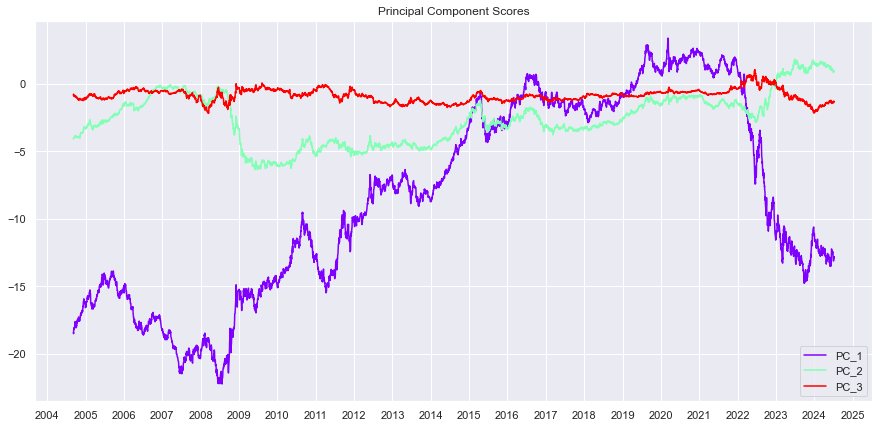

In [165]:
fig, ax = plt.subplots(1, 1, figsize = (15,7))
colors = rainbow(pc_idx[:min(3,k)])

# Plotting
for i in pc_idx[:min(3,k)]:
    plt.plot(pc_scores[i], c = colors[i], label = i)

# Formatting
ax.set_title ("Principal Component Scores")
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years_loc)
ax.xaxis.set_minor_locator(months_loc)

ax.legend(loc = "lower right")
plt.show()

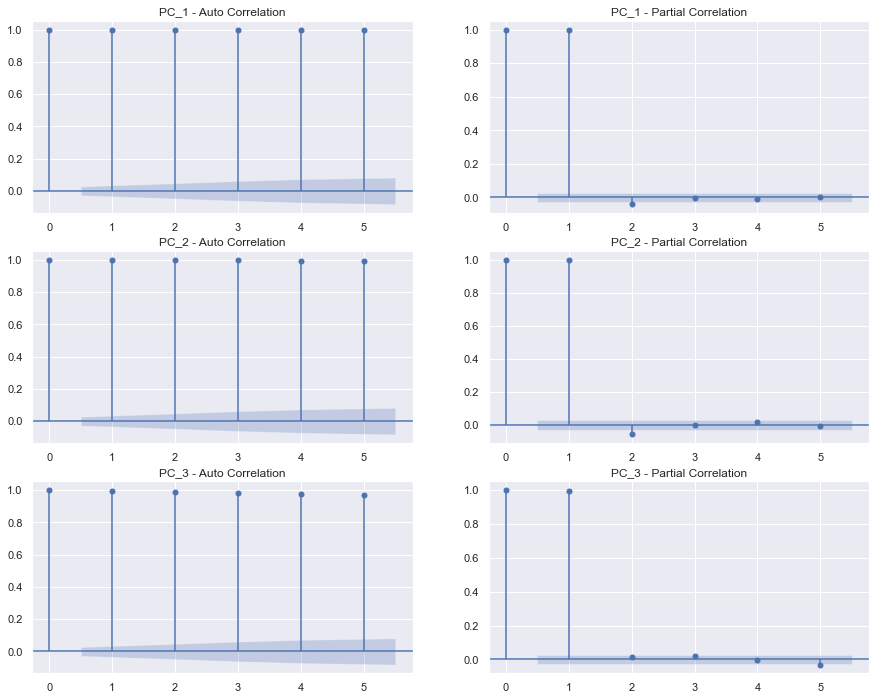

In [166]:
fig, ax = plt.subplots(k, 2, figsize=(15,4*k))

for i,j in enumerate (pc_idx):
    plot_acf (pc_scores[j], lags= lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(pc_scores[j], lags= lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

#### 5.2 First Differences

In [167]:
periods = 1
for i in pc_idx:
    pc_scores[i+"_diff"] = pc_scores[i].diff(periods)    
    
pc_scores = pc_scores.iloc[periods:]
pc_scores.head()

PC_1      PC_2      PC_3  PC_1_diff  PC_2_diff  PC_3_diff
DATE                                                                      
2004-09-07 -18.450673 -4.022564 -0.798445  -0.024885   0.065377   0.040994
2004-09-08 -18.523930 -4.005387 -0.760739  -0.073257   0.017177   0.037705
2004-09-09 -18.276416 -3.997398 -0.843682   0.247515   0.007989  -0.082942
2004-09-10 -18.096785 -4.003847 -0.901017   0.179631  -0.006449  -0.057335
2004-09-13 -18.197863 -3.968559 -0.862240  -0.101078   0.035289   0.038777

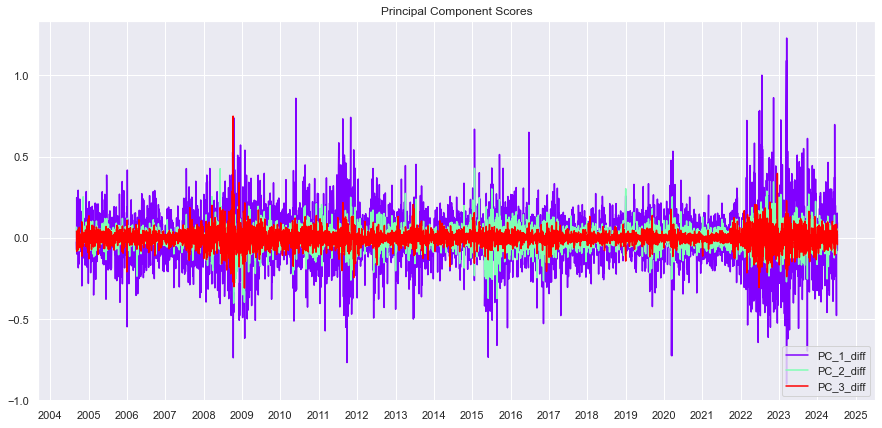

In [168]:
fig, ax = plt.subplots(1, 1, figsize = (15,7))

pc_idx_diff = [i+"_diff" for i in pc_idx]
colors = rainbow(pc_idx_diff)

# Plotting
for i in pc_idx_diff:
    plt.plot(pc_scores[i], c = colors[i], label = i)

# Formatting
ax.set_title ("Principal Component Scores")
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(years_loc)
ax.xaxis.set_minor_locator(months_loc)

ax.legend(loc = "lower right")
plt.show()

In [169]:
for i in pc_idx_diff:
    underline (f'Stationarity-Test: {i}')
    print (adf_test(df = pc_scores, col = i, alpha = "5%"))

Stationarity-Test: PC_1_diff
{'adf_stat': -23.5773, 'p_val': 0.0, 'threshold': -2.8621, 'stationary': 'yes'}
Stationarity-Test: PC_2_diff
{'adf_stat': -12.8361, 'p_val': 0.0, 'threshold': -2.8621, 'stationary': 'yes'}
Stationarity-Test: PC_3_diff
{'adf_stat': -13.4876, 'p_val': 0.0, 'threshold': -2.8621, 'stationary': 'yes'}


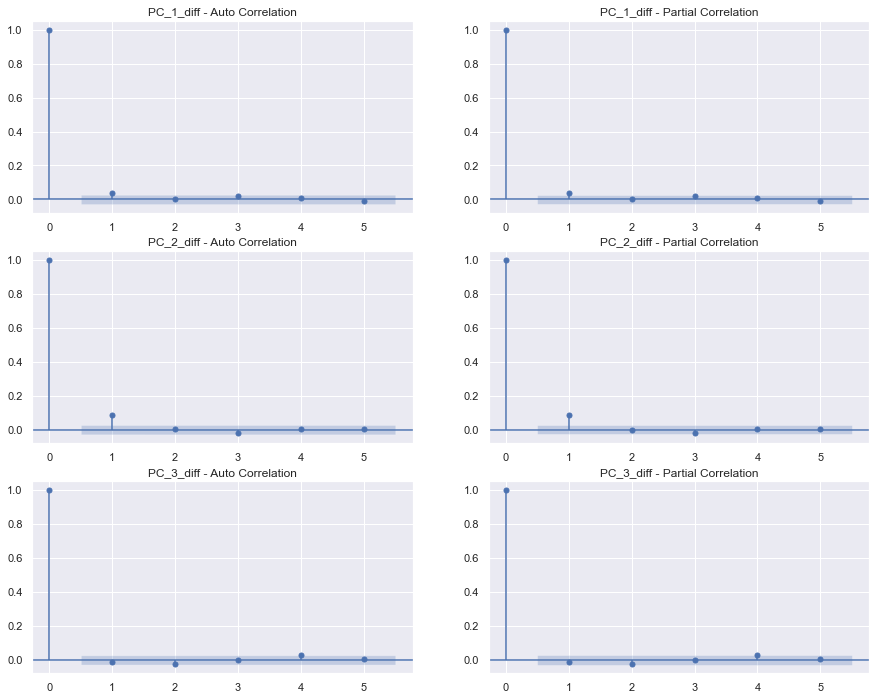

In [170]:
fig, ax = plt.subplots(k, 2, figsize=(15,4*k))

for i,j in enumerate (pc_idx_diff):
    plot_acf (pc_scores[j], lags= lag, ax=ax[i][0], title=j+" - Auto Correlation")
    plot_pacf(pc_scores[j], lags= lag, ax=ax[i][1], title=j+" - Partial Correlation")

plt.show()

The ACF and PACF plots for the differenced principal component scores indicate that the series have become stationary after differencing. The sharp drop in autocorrelation and partial autocorrelation after the first lag suggests that an AR(1) model might be appropriate for these series. Alternatively, an ARIMA(1,1,0) model can also be considered for further modeling.

### 6. Stress Scenerios

In [172]:
# Shift in PC1
unit = 30
trail = 24
pc_shift = dict()
pc_shift_idx = pc_scores.index[unit:]


# Create shifts for each pc
for i in pc_idx2:
    pc_shift[i] = pc_model.eig_scores[i].diff(unit)
    pc_shift[i] = pc_shift[i].dropna()
    
    # Test shifts for stationarity
    stationary = adf_test(pd.DataFrame(pc_shift[i]), i, "5%")
    print (f'{i}: {stationary}')

PC_1: {'adf_stat': -7.311, 'p_val': 0.0, 'threshold': -2.8621, 'stationary': 'yes'}
PC_2: {'adf_stat': -6.1152, 'p_val': 0.0, 'threshold': -2.8621, 'stationary': 'yes'}
PC_3: {'adf_stat': -7.9022, 'p_val': 0.0, 'threshold': -2.8621, 'stationary': 'yes'}


In [173]:
# Create up and down scenarios
pc_scores_up, pc_scores_down = dict(), dict()

# Iterate through first 3 PCs
for j in pc_idx2:
    
    # For each PC find highest/lowest 5% shift
    up, down = list(), list()
    
    for i in range(len(pc_shift_idx)):
        temp = pc_shift[j][i:i+unit*trail].sort_values()
        obs = int(len(temp)*0.05)
        
        up.append(temp[obs])
        down.append(temp[-obs])
    
    # Add shift to PC score
    pc_scores_up[j] = pc_scores[j].iloc[unit:] + pd.Series(up, index=pc_shift_idx)
    pc_scores_down[j] = pc_scores[j].iloc[unit:] + pd.Series(down, index=pc_shift_idx)

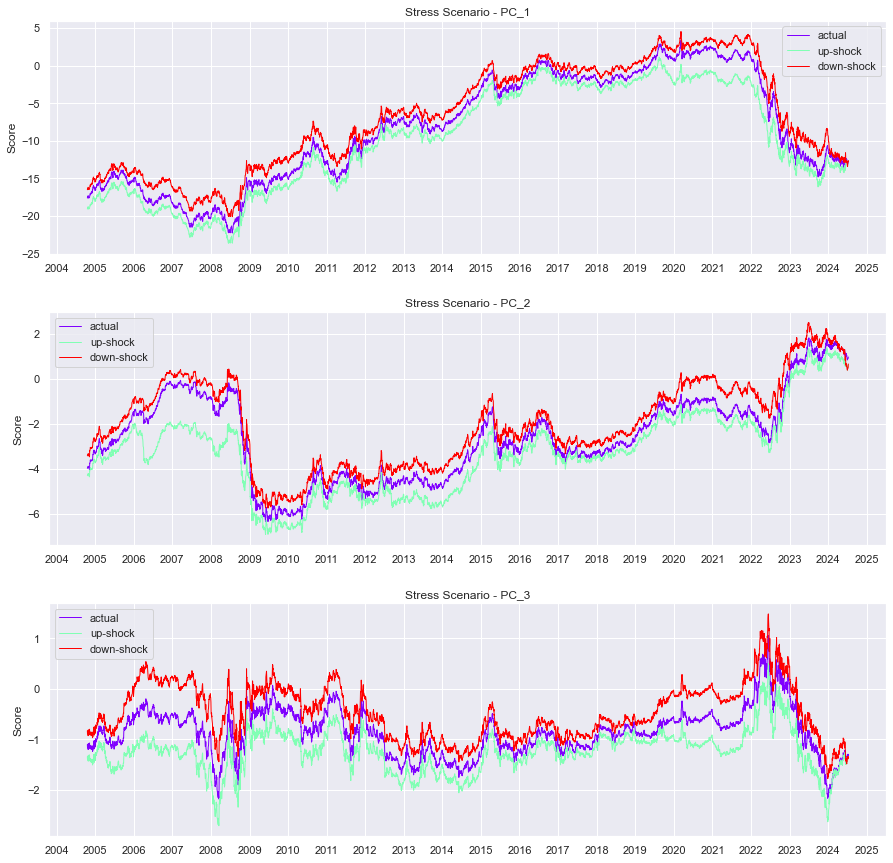

In [174]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
color = rainbow(["actual","up","down"])

# Plots
for i,j in enumerate(pc_idx2):
    ax[i].plot (pc_scores[j].iloc[unit:], c=color["actual"], label="actual", linewidth=1)
    ax[i].plot (pc_scores_up[j], c=color["up"], label="up-shock", linewidth=1)
    ax[i].plot (pc_scores_down[j], c=color["down"], label="down-shock", linewidth=1)

    # Formatting
    ax[i].set_title (f'Stress Scenario - {j}')
    ax[i].set_ylabel ("Score")
    ax[i].xaxis.set_major_formatter(years_fmt)
    ax[i].xaxis.set_major_locator(years_loc)
    ax[i].xaxis.set_minor_locator(months_loc)
    ax[i].legend()
    
plt.subplots_adjust(hspace=0.25)
plt.show()

In [175]:
# Create dictionary of dataframes per each PC
pc_yields_up, pc_yields_down = dict(), dict()

for i in pc_idx2:

    # Dataframe of pc scores, where only 1 PC is stressed
    temp1 = pc_scores.iloc[unit:,:3].copy()
    temp1[i] = pc_scores_up[i]

    temp2 = pc_scores.iloc[unit:,:3].copy()
    temp2[i] = pc_scores_down[i]

    # Backtransformed pc scores into stressed model yields
    pc_yields_up[i] = np.matrix(temp1) * np.matrix(pc_vect_inv)
    pc_yields_up[i] = pd.DataFrame(data=pc_yields_up[i], columns=mat_all, index=pc_shift_idx)

    pc_yields_down[i] = np.matrix(temp2) * np.matrix(pc_vect_inv)
    pc_yields_down[i] = pd.DataFrame(data=pc_yields_down[i], columns=mat_all, index=pc_shift_idx)

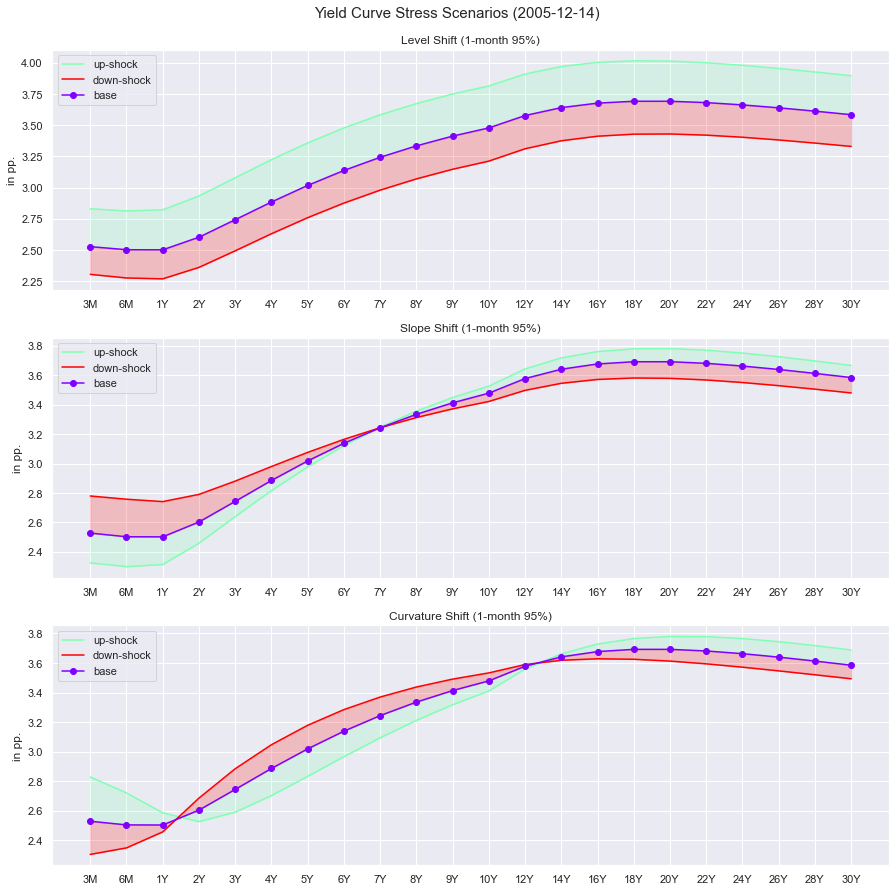

In [176]:
element = 300
date = pc_yields.index[element+unit].strftime("%Y-%m-%d")

fig, ax = plt.subplots(3, 1, figsize = (15,15))
fig.suptitle("Yield Curve Stress Scenarios ("+date+")", fontsize=15, y=0.92)
color = rainbow(["actual","up","down"])


# Create plot
for i,j in enumerate (pc_idx2):
    
    up   = pc_yields_up[j].iloc[element]
    down = pc_yields_down[j].iloc[element]
    act  = pc_yields.iloc[element+unit]
    
    ax[i].plot(mat_all, up, label="up-shock", c=color["up"])
    ax[i].plot(mat_all, down, label="down-shock", c=color["down"])
    ax[i].plot(mat_all, act, label="base", c=color["actual"], marker="o")
    
    ax[i].fill_between(mat_all, up, act, color = color["up"], alpha = 0.2)
    ax[i].fill_between(mat_all, down, act, color = color["down"], alpha = 0.2)
    
    ax[i].set_ylabel ("in pp.")
    ax[i].legend()


# Formatting
ax[0].set_title ("Level Shift (1-month 95%)")
ax[1].set_title ("Slope Shift (1-month 95%)")
ax[2].set_title ("Curvature Shift (1-month 95%)")


plt.show()

### 7. Prediction

#### 7.1 Model Fit

In [202]:
# Train-test split for model yields
pc_yields_train = pc_yields[pc_yields.index < test_start]
pc_yields_test  = pc_yields[pc_yields.index >= test_start]

# Train-test split for pc scores
pc_scores_train = pc_scores[pc_scores.index < test_start]
pc_scores_test  = pc_scores[pc_scores.index >= test_start]

# Last train observation
pc_scores_last_train = pc_scores_train.iloc[-1,:k]
pc_scores_last_train

PC_1   -1.841480
PC_2   -3.329885
PC_3   -0.927948
Name: 2017-12-29 00:00:00, dtype: float64

In [203]:
model = ar.Model(train=pc_scores_train, 
                 test=pc_scores_test, 
                 last_train=pc_scores_last_train,
                 alpha=0.05,
                 diff=diff)

In [204]:
pc_scores_test

PC_1      PC_2      PC_3  PC_1_diff  PC_2_diff  PC_3_diff
DATE                                                                      
2018-01-02  -1.942921 -3.336169 -0.974302  -0.101440  -0.006284  -0.046353
2018-01-03  -1.885648 -3.253000 -1.009170   0.057273   0.083169  -0.034868
2018-01-04  -1.926025 -3.211161 -0.992596  -0.040377   0.041839   0.016574
2018-01-05  -1.907480 -3.204927 -1.014029   0.018545   0.006234  -0.021434
2018-01-08  -1.854919 -3.185141 -1.044164   0.052561   0.019787  -0.030134
...               ...       ...       ...        ...        ...        ...
2024-07-04 -13.077757  0.904398 -1.295145   0.053857   0.005595   0.043004
2024-07-05 -12.989619  0.895892 -1.313538   0.088138  -0.008505  -0.018393
2024-07-08 -12.837989  0.917752 -1.316512   0.151630   0.021860  -0.002974
2024-07-09 -12.915737  0.926400 -1.294054  -0.077748   0.008648   0.022458
2024-07-10 -12.822186  0.980498 -1.335849   0.093551   0.054097  -0.041796

[1663 rows x 6 columns]

In [205]:
model.fit(lag=lag)

                                   PC_1_diff                                    
                               AR Model Results                               
Dep. Variable:                      y   No. Observations:                 3410
Model:                          AR(5)   Log Likelihood                1482.122
Method:                          cmle   S.D. of innovations              0.157
Date:                Sat, 13 Jul 2024   AIC                             -3.704
Time:                        15:53:07   BIC                             -3.692
Sample:                             0   HQIC                            -3.700
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.003      1.693      0.090      -0.001       0.010
L1.y           0.0771      0.017      4.494      0

#### 7.2 Model Results

In [210]:
pc_scores_pred = model.predict(steps=steps, components_pred=["PC_1_diff","PC_2_diff","PC_3_diff"])
pc_scores_pred.iloc[:5,:10]

PC_1      PC_2      PC_3
2018-01-02 -1.848476 -3.342353 -0.927567
2018-01-03 -1.950739 -3.337056 -0.975216
2018-01-04 -1.881234 -3.241260 -1.010011
2018-01-05 -1.929137 -3.205255 -0.992416
2018-01-08 -1.906051 -3.204047 -1.016019

In [222]:
yield_pred = model.back_transform(pc_vect_inv=pc_vect_inv, maturities=mat_all)
yield_pred.iloc[:5,:10]

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2018-01-02 -0.614778 -0.741845 -0.835678 -0.762196 -0.584998 -0.382532   
2018-01-03 -0.570996 -0.703976 -0.807521 -0.745813 -0.574199 -0.373895   
2018-01-04 -0.528347 -0.665960 -0.779975 -0.736005 -0.576795 -0.385060   
2018-01-05 -0.512174 -0.647111 -0.758113 -0.712525 -0.554006 -0.363903   
2018-01-08 -0.505263 -0.643450 -0.759640 -0.720291 -0.564768 -0.375867   

                  5Y        6Y        7Y        8Y  
DATE                                                
2018-01-02 -0.178370  0.016630  0.196744  0.359181  
2018-01-03 -0.169905  0.026074  0.207797  0.372141  
2018-01-04 -0.187022  0.004814  0.183667  0.346048  
2018-01-05 -0.167923  0.021707  0.198368  0.358671  
2018-01-08 -0.180031  0.010074  0.187556  0.348849

In [212]:
yield_pred.to_csv("/Users/neelpatel/Documents/Resume_Projects/PCA_Yield_Curve_Analytics/prediction.csv")

#### 7.3 Actuals

In [214]:
yield_act = clean_rates[clean_rates.index >= test_start].iloc[:steps]
yield_act.iloc[:5,:10]

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2018-01-02 -0.745998 -0.738445 -0.712228 -0.618449 -0.483050 -0.324544   
2018-01-03 -0.689726 -0.699190 -0.696930 -0.625850 -0.496899 -0.339074   
2018-01-04 -0.664711 -0.677090 -0.678375 -0.609208 -0.479648 -0.321098   
2018-01-05 -0.659469 -0.672334 -0.675266 -0.610466 -0.484993 -0.329451   
2018-01-08 -0.646781 -0.664524 -0.675209 -0.620244 -0.499954 -0.346989   

                  5Y        6Y        7Y        8Y  
DATE                                                
2018-01-02 -0.158394  0.004649  0.158085  0.298607  
2018-01-03 -0.172192 -0.008581  0.144852  0.284841  
2018-01-04 -0.154146  0.008797  0.160989  0.299369  
2018-01-05 -0.164337 -0.002245  0.149828  0.288587  
2018-01-08 -0.182959 -0.021089  0.131257  0.270563

#### 7.4 Benchmark

In [215]:
yield_pred_bm = yield_act.shift(1)
yield_pred_bm.iloc[0] = clean_rates[clean_rates.index < test_start].iloc[-1]
yield_pred_bm.iloc[:5,:10]

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2018-01-02 -0.780057 -0.769592 -0.737874 -0.635217 -0.494164 -0.332811   
2018-01-03 -0.745998 -0.738445 -0.712228 -0.618449 -0.483050 -0.324544   
2018-01-04 -0.689726 -0.699190 -0.696930 -0.625850 -0.496899 -0.339074   
2018-01-05 -0.664711 -0.677090 -0.678375 -0.609208 -0.479648 -0.321098   
2018-01-08 -0.659469 -0.672334 -0.675266 -0.610466 -0.484993 -0.329451   

                  5Y        6Y        7Y        8Y  
DATE                                                
2018-01-02 -0.165891 -0.003460  0.148531  0.287169  
2018-01-03 -0.158394  0.004649  0.158085  0.298607  
2018-01-04 -0.172192 -0.008581  0.144852  0.284841  
2018-01-05 -0.154146  0.008797  0.160989  0.299369  
2018-01-08 -0.164337 -0.002245  0.149828  0.288587

#### 7.5 Error

In [220]:
yield_pred

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2018-01-02 -0.614778 -0.741845 -0.835678 -0.762196 -0.584998 -0.382532   
2018-01-03 -0.570996 -0.703976 -0.807521 -0.745813 -0.574199 -0.373895   
2018-01-04 -0.528347 -0.665960 -0.779975 -0.736005 -0.576795 -0.385060   
2018-01-05 -0.512174 -0.647111 -0.758113 -0.712525 -0.554006 -0.363903   
2018-01-08 -0.505263 -0.643450 -0.759640 -0.720291 -0.564768 -0.375867   
...              ...       ...       ...       ...       ...       ...   
2018-05-18 -0.527256 -0.638085 -0.709326 -0.613163 -0.428006 -0.225037   
2018-05-21 -0.506697 -0.622292 -0.701591 -0.615801 -0.436114 -0.235785   
2018-05-22 -0.510233 -0.631804 -0.721942 -0.651741 -0.481625 -0.287073   
2018-05-23 -0.513827 -0.631381 -0.716075 -0.641024 -0.469884 -0.276131   
2018-05-24 -0.504423 -0.628812 -0.725115 -0.665351 -0.502621 -0.313232   

                  5Y        6Y        7Y        8Y  ...       12Y       14Y  \
DATE                                                ...                       
2018-01-02 -0.178370  0.016630  0.196744  0.359181  ...  0.827947  0.968643   
2018-01-03 -0.169905  0.026074  0.207797  0.372141  ...  0.848392  0.991919   
2018-01-04 -0.187022  0.004814  0.183667  0.346048  ...  0.819399  0.962906   
2018-01-05 -0.167923  0.021707  0.198368  0.358671  ...  0.825555  0.966962   
2018-01-08 -0.180031  0.010074  0.187556  0.348849  ...  0.819700  0.962643   
...              ...       ...       ...       ...  ...       ...       ...   
2018-05-18 -0.024547  0.164503  0.337581  0.492649  ...  0.935454  1.066795   
2018-05-21 -0.036230  0.152919  0.326703  0.482809  ...  0.930383  1.063699   
2018-05-22 -0.090849  0.096564  0.269648  0.425720  ...  0.875885  1.010844   
2018-05-23 -0.081658  0.103541  0.274245  0.427949  ...  0.870313  1.002632   
2018-05-24 -0.120633  0.064231  0.235534  0.390376  ...  0.838685  0.973629   

                 16Y       18Y       20Y       22Y       24Y       26Y  \
DATE                                                                     
2018-01-02  1.062532  1.120622  1.152120  1.164360  1.163011  1.152353   
2018-01-03  1.087927  1.147507  1.179980  1.192794  1.191717  1.181108   
2018-01-04  1.059264  1.119365  1.152422  1.165827  1.165320  1.155247   
2018-01-05  1.061839  1.120951  1.153393  1.166461  1.165815  1.155745   
2018-01-08  1.058694  1.118660  1.151693  1.165146  1.164729  1.154773   
...              ...       ...       ...       ...       ...       ...   
2018-05-18  1.153686  1.206750  1.234783  1.244751  1.242014  1.230603   
2018-05-21  1.152137  1.206350  1.235197  1.245710  1.243310  1.232084   
2018-05-22  1.100776  1.156268  1.186172  1.197549  1.195851  1.185196   
2018-05-23  1.090676  1.144892  1.173999  1.184939  1.183066  1.172425   
2018-05-24  1.063797  1.119652  1.149977  1.161793  1.160531  1.150300   

                 28Y       30Y  
DATE                            
2018-01-02  1.135558  1.114940  
2018-01-03  1.164206  1.143374  
2018-01-04  1.138844  1.118474  
2018-01-05  1.139438  1.119227  
2018-01-08  1.138499  1.118264  
...              ...       ...  
2018-05-18  1.213503  1.192885  
2018-05-21  1.215057  1.194434  
2018-05-22  1.168640  1.148411  
2018-05-23  1.156011  1.136008  
2018-05-24  1.134149  1.114304  

[100 rows x 22 columns]

In [221]:
clean_rates_test

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2018-01-02 -0.745998 -0.738445 -0.712228 -0.618449 -0.483050 -0.324544   
2018-01-03 -0.689726 -0.699190 -0.696930 -0.625850 -0.496899 -0.339074   
2018-01-04 -0.664711 -0.677090 -0.678375 -0.609208 -0.479648 -0.321098   
2018-01-05 -0.659469 -0.672334 -0.675266 -0.610466 -0.484993 -0.329451   
2018-01-08 -0.646781 -0.664524 -0.675209 -0.620244 -0.499954 -0.346989   
...              ...       ...       ...       ...       ...       ...   
2024-07-04  3.453070  3.348964  3.167274  2.894133  2.715794  2.607636   
2024-07-05  3.437296  3.332659  3.149810  2.874237  2.693667  2.583725   
2024-07-08  3.424020  3.315713  3.126893  2.843711  2.659583  2.548598   
2024-07-09  3.436777  3.329254  3.141961  2.861570  2.679771  2.570597   
2024-07-10  3.455135  3.344166  3.150354  2.858445  2.667133  2.550335   

                  5Y        6Y        7Y        8Y  ...       12Y       14Y  \
DATE                                                ...                       
2018-01-02 -0.158394  0.004649  0.158085  0.298607  ...  0.725001  0.870810   
2018-01-03 -0.172192 -0.008581  0.144852  0.284841  ...  0.706840  0.850445   
2018-01-04 -0.154146  0.008797  0.160989  0.299369  ...  0.714207  0.854750   
2018-01-05 -0.164337 -0.002245  0.149828  0.288587  ...  0.706836  0.849153   
2018-01-08 -0.182959 -0.021089  0.131257  0.270563  ...  0.691724  0.835372   
...              ...       ...       ...       ...  ...       ...       ...   
2024-07-04  2.550591  2.529966  2.534510  2.555670  ...  2.700301  2.767826   
2024-07-05  2.525447  2.504151  2.508546  2.530007  ...  2.678642  2.748794   
2024-07-08  2.490727  2.470567  2.476346  2.499143  ...  2.650225  2.719662   
2024-07-09  2.514013  2.494647  2.500777  2.523541  ...  2.671837  2.739002   
2024-07-10  2.487843  2.464081  2.467119  2.487892  ...  2.635713  2.705226   

                 16Y       18Y       20Y       22Y       24Y       26Y  \
DATE                                                                     
2018-01-02  0.985105  1.075991  1.149487  1.209929  1.260415  1.303180   
2018-01-03  0.962874  1.052225  1.124464  1.183865  1.233482  1.275510   
2018-01-04  0.964630  1.051888  1.122404  1.180376  1.228794  1.269804   
2018-01-05  0.960575  1.049129  1.120726  1.179601  1.228778  1.270434   
2018-01-08  0.947927  1.037427  1.109810  1.169342  1.219072  1.261199   
...              ...       ...       ...       ...       ...       ...   
2024-07-04  2.818396  2.849573  2.861886  2.857333  2.838499  2.808070   
2024-07-05  2.801827  2.835068  2.848928  2.845375  2.827018  2.796599   
2024-07-08  2.771055  2.802094  2.813507  2.807497  2.786841  2.754380   
2024-07-09  2.787936  2.816514  2.825582  2.817408  2.794798  2.760600   
2024-07-10  2.757220  2.789113  2.801461  2.796369  2.776557  2.744844   

                 28Y       30Y  
DATE                            
2018-01-02  1.339852  1.371642  
2018-01-03  1.311551  1.342792  
2018-01-04  1.304971  1.335455  
2018-01-05  1.306157  1.337122  
2018-01-08  1.297326  1.328643  
...              ...       ...  
2024-07-04  2.768571  2.722247  
2024-07-05  2.756716  2.709687  
2024-07-08  2.712764  2.664330  
2024-07-09  2.717456  2.667687  
2024-07-10  2.703873  2.655986  

[1663 rows x 22 columns]

In [216]:
e_pred = yield_pred - clean_rates_test
e_pred = e_pred[:steps]
e_pred.iloc[:5,:10]

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2018-01-02  0.131220 -0.003400 -0.123450 -0.143747 -0.101948 -0.057988   
2018-01-03  0.118730 -0.004786 -0.110591 -0.119963 -0.077300 -0.034821   
2018-01-04  0.136364  0.011130 -0.101600 -0.126797 -0.097147 -0.063962   
2018-01-05  0.147295  0.025223 -0.082847 -0.102059 -0.069013 -0.034452   
2018-01-08  0.141518  0.021074 -0.084431 -0.100047 -0.064814 -0.028878   

                  5Y        6Y        7Y        8Y  
DATE                                                
2018-01-02 -0.019976  0.011981  0.038659  0.060574  
2018-01-03  0.002287  0.034655  0.062945  0.087300  
2018-01-04 -0.032876 -0.003983  0.022678  0.046679  
2018-01-05 -0.003586  0.023952  0.048540  0.070084  
2018-01-08  0.002928  0.031163  0.056299  0.078286

In [217]:
e_naive = yield_pred_bm - clean_rates_test
e_naive = e_naive[:steps]
e_naive.iloc[:5,:10]

3M        6M        1Y        2Y        3Y        4Y  \
DATE                                                                     
2018-01-02 -0.034059 -0.031147 -0.025646 -0.016768 -0.011114 -0.008267   
2018-01-03 -0.056272 -0.039255 -0.015298  0.007401  0.013849  0.014530   
2018-01-04 -0.025015 -0.022100 -0.018555 -0.016642 -0.017251 -0.017976   
2018-01-05 -0.005242 -0.004756 -0.003109  0.001258  0.005345  0.008353   
2018-01-08 -0.012688 -0.007810 -0.000057  0.009778  0.014961  0.017538   

                  5Y        6Y        7Y        8Y  
DATE                                                
2018-01-02 -0.007497 -0.008109 -0.009554 -0.011438  
2018-01-03  0.013798  0.013230  0.013233  0.013766  
2018-01-04 -0.018046 -0.017378 -0.016137 -0.014528  
2018-01-05  0.010191  0.011042  0.011161  0.010782  
2018-01-08  0.018622  0.018844  0.018571  0.018024

In [218]:
rmse_pred  = np.sqrt((e_pred**2).sum(axis=1))
rmse_naive = np.sqrt((e_naive**2).sum(axis=1))

print (f"RMSE of prediction model:{rmse_pred.sum()/steps}")
print (f"RMSE of benchmark model: {rmse_naive.sum()/steps}")

RMSE of prediction model:0.3711596045762885
RMSE of benchmark model: 0.09037261901422239


### 8. Evaluation

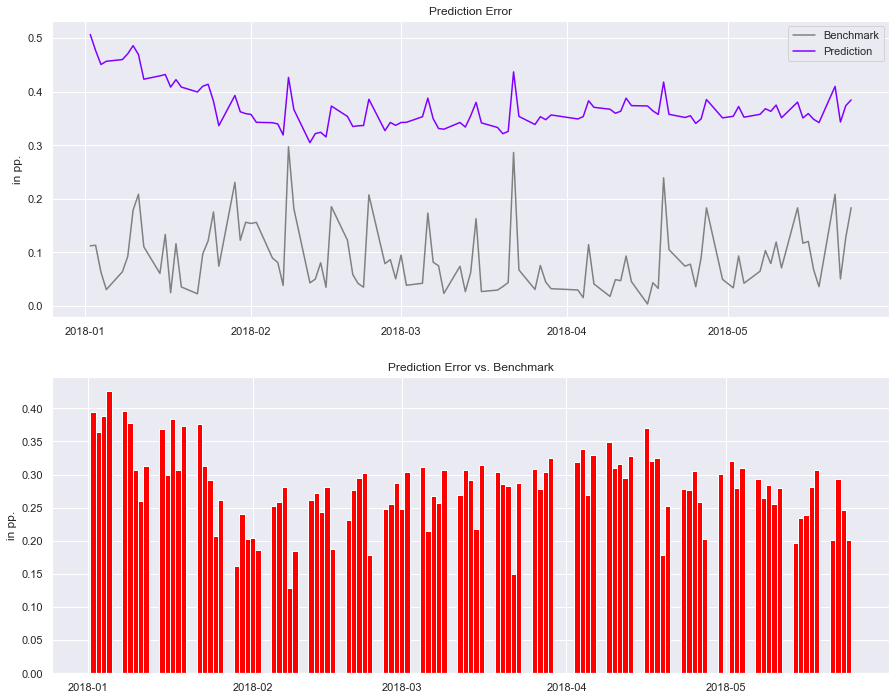

In [219]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,12))
color = rainbow(["pred","neg","pos"])
color_bar=(rmse_pred-rmse_naive > 0).map({True: color["pos"], False: color["neg"]})

# Plots
ax1.plot(rmse_naive, c="grey", label="Benchmark")
ax1.plot(rmse_pred, c=color["pred"], label="Prediction")
ax2.bar(x=rmse_pred.index, height=rmse_pred-rmse_naive, width=1, color=color_bar)



# Formatting
ax1.set_title ("Prediction Error")
ax1.set_ylabel ("in pp.")
ax1.xaxis.set_major_formatter(months_fmt)
ax1.xaxis.set_major_locator(months_loc)
ax1.legend()

ax2.set_title ("Prediction Error vs. Benchmark")
ax2.set_ylabel ("in pp.")
ax2.xaxis.set_major_formatter(months_fmt)
ax2.xaxis.set_major_locator(months_loc)

plt.show()

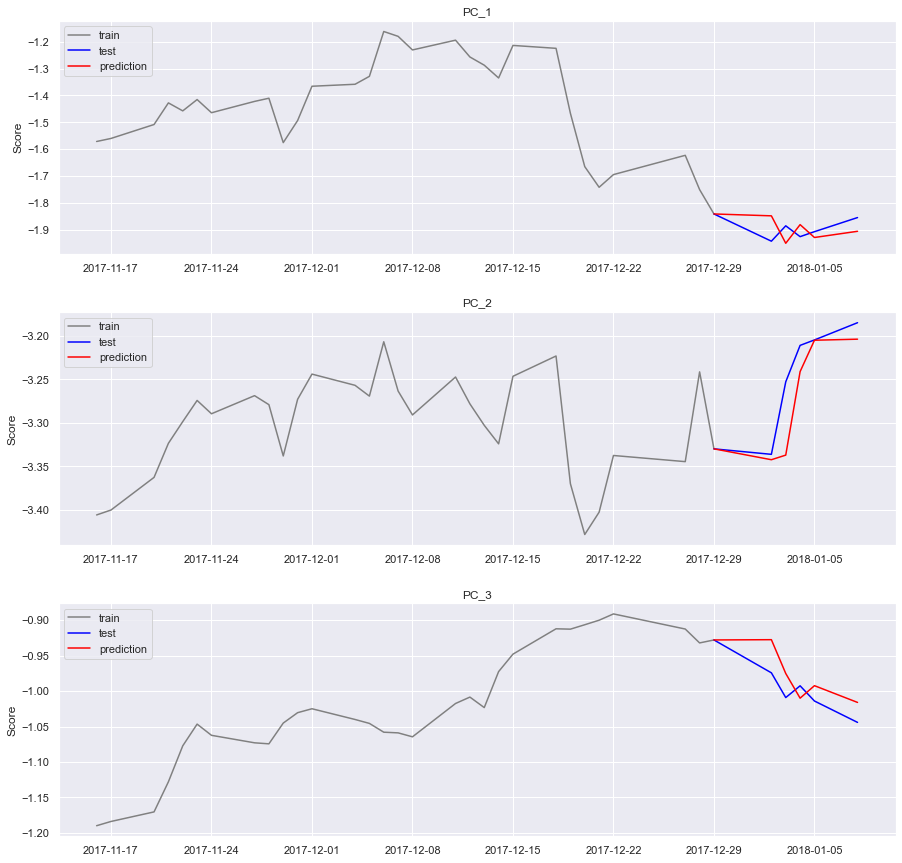

In [223]:
days_hist = 30
horizon = 5

fig, ax = plt.subplots(k, 1, figsize = (15,5*k))

chart_train = pc_scores_train.iloc[-days_hist:,:]
chart_test = pd.concat([pc_scores_train.iloc[-1:], pc_scores_test.iloc[:horizon]], axis = 0)
chart_pred = pd.concat([pc_scores_train.iloc[-1:], pc_scores_pred[:horizon]], axis =0)

for i,j in enumerate (pc_idx):
    
    # Ploting
    ax[i].plot(chart_train[j], c="grey", label = "train")
    ax[i].plot(chart_test[j], c="blue",  label = "test")
    ax[i].plot(chart_pred[j], c="red",   label = "prediction")

    # Formatting
    ax[i].set_title (j)
    ax[i].set_ylabel ("Score")
    
    ax[i].xaxis.set_major_formatter(days_fmt)
    ax[i].xaxis.set_major_locator(days_loc)
    ax[i].legend(loc="upper left")

plt.subplots_adjust(hspace=0.25)
plt.show()

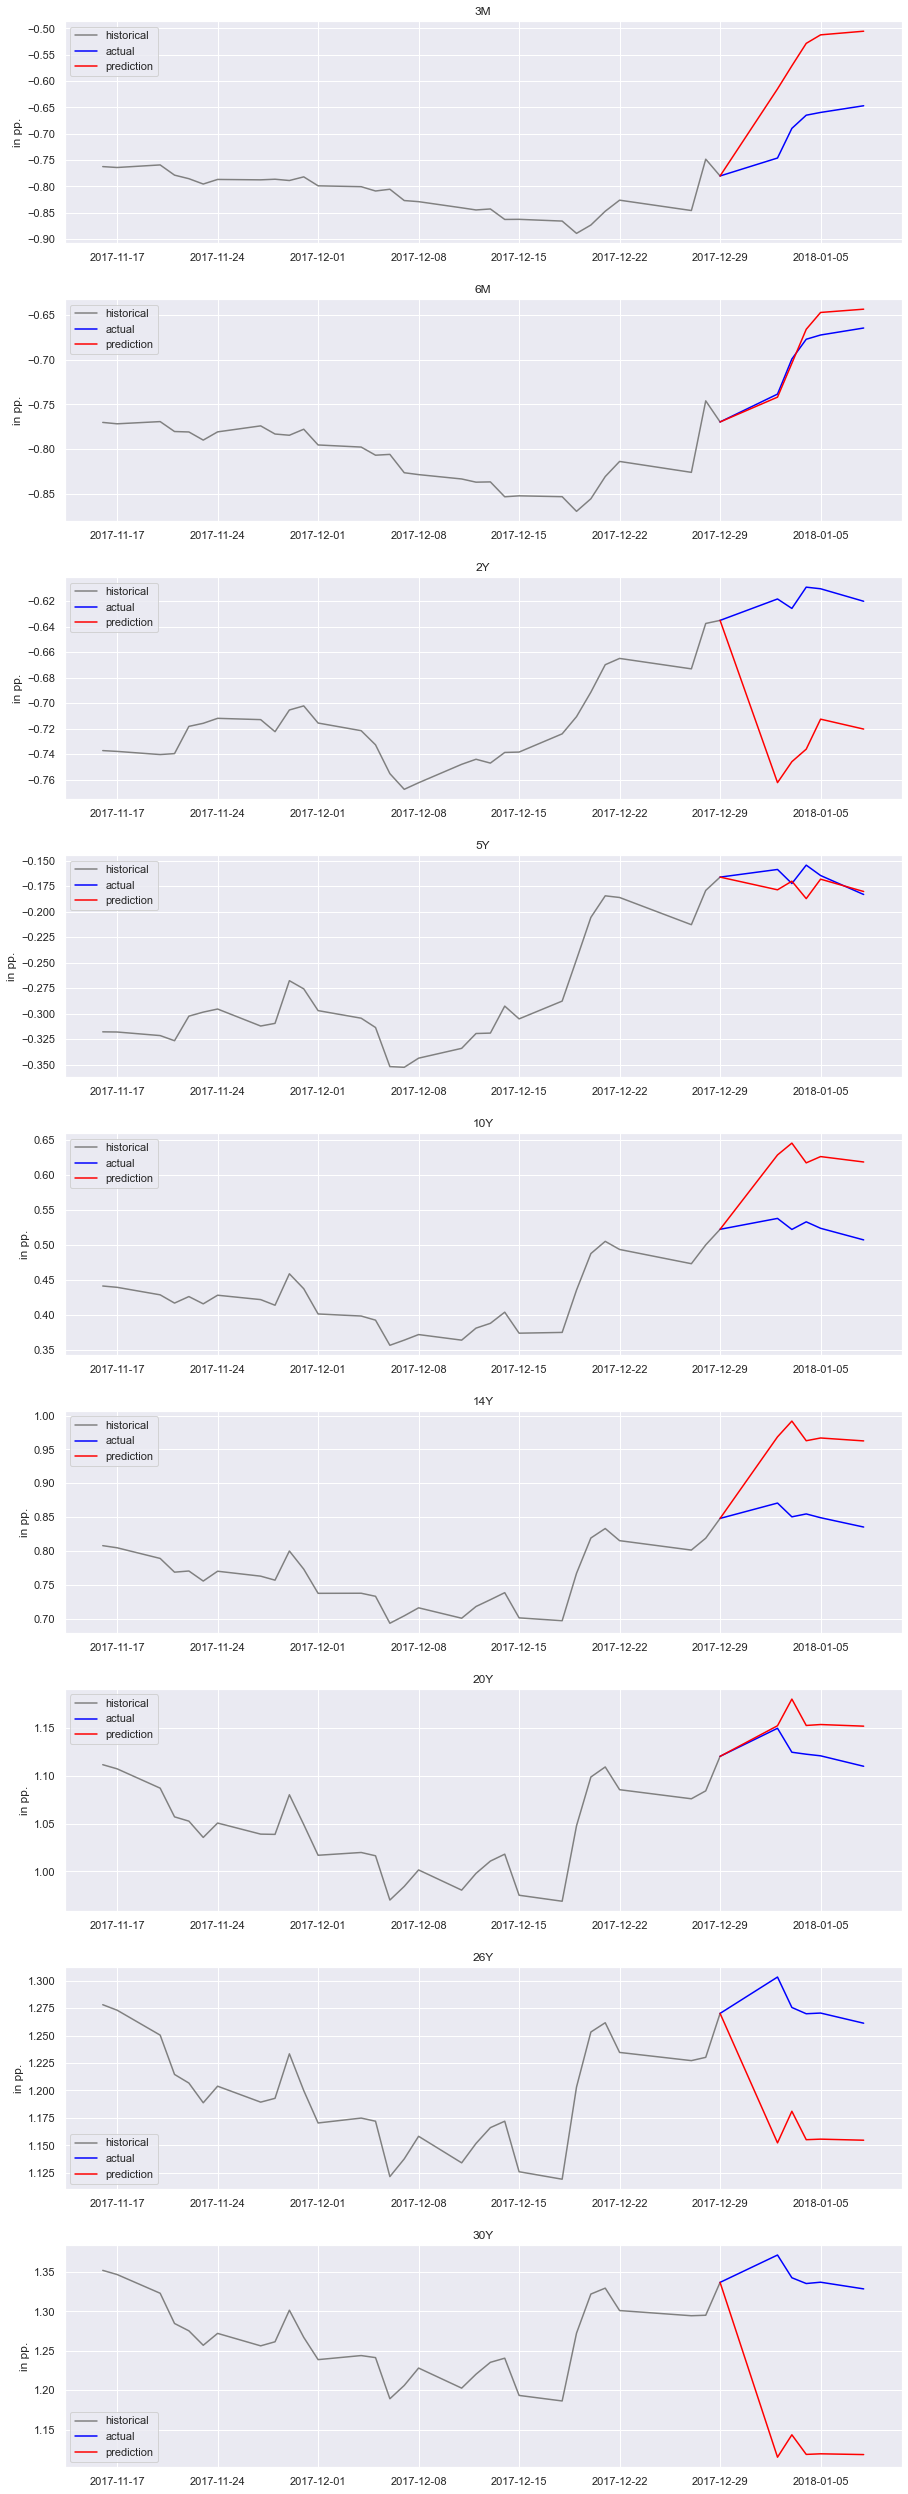

In [225]:
fig, ax = plt.subplots(nrows = len(mat_vis), ncols = 1, figsize = (15,5*len(mat_vis)))

chart_hist = clean_rates_train.iloc[-days_hist:,:]
chart_act  = pd.concat([clean_rates_train.iloc[-1:], yield_act[:horizon]], axis = 0)
chart_pred = pd.concat([clean_rates_train.iloc[-1:], yield_pred[:horizon]], axis = 0)

for i,j in enumerate(mat_vis):
    ax[i].plot (chart_hist[j],          c="grey", label = "historical")
    ax[i].plot (chart_act[j][:steps+1], c="blue", label = "actual")
    ax[i].plot (chart_pred[j],          c="red",  label = "prediction")

    ax[i].set_title (j)
    ax[i].set_ylabel ("in pp.")

    ax[i].xaxis.set_major_formatter(days_fmt)
    ax[i].xaxis.set_major_locator(days_loc)
    ax[i].legend()

plt.subplots_adjust(hspace=0.25)
plt.show()

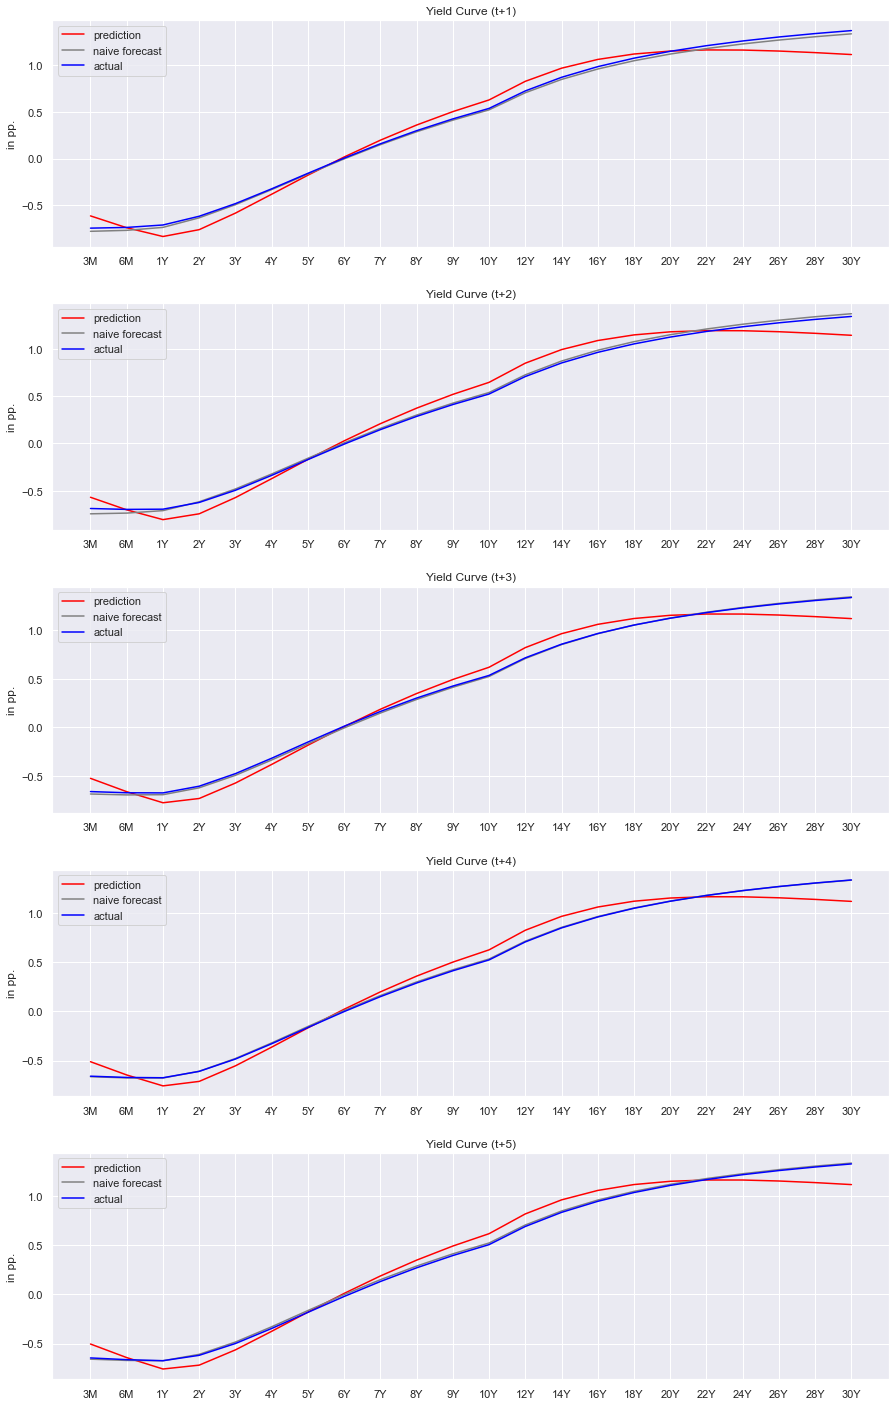

In [226]:
fig, ax = plt.subplots(nrows = horizon, 
                       ncols = 1, 
                       figsize = (15,horizon*5))

for i in range(horizon):
    ax[i].plot (yield_pred.iloc[i,:],    c="red",  label = "prediction")
    ax[i].plot (yield_pred_bm.iloc[i,:], c="grey", label = "naive forecast")
    ax[i].plot (yield_act.iloc[i,:],     c="blue", label = "actual")

    # Format
    ax[i].set_title (f'Yield Curve (t+{i+1})')
    ax[i].set_ylabel ("in pp.")
    ax[i].legend()

    
plt.subplots_adjust(hspace=0.25)
plt.show()

<IPython.core.display.Javascript object>


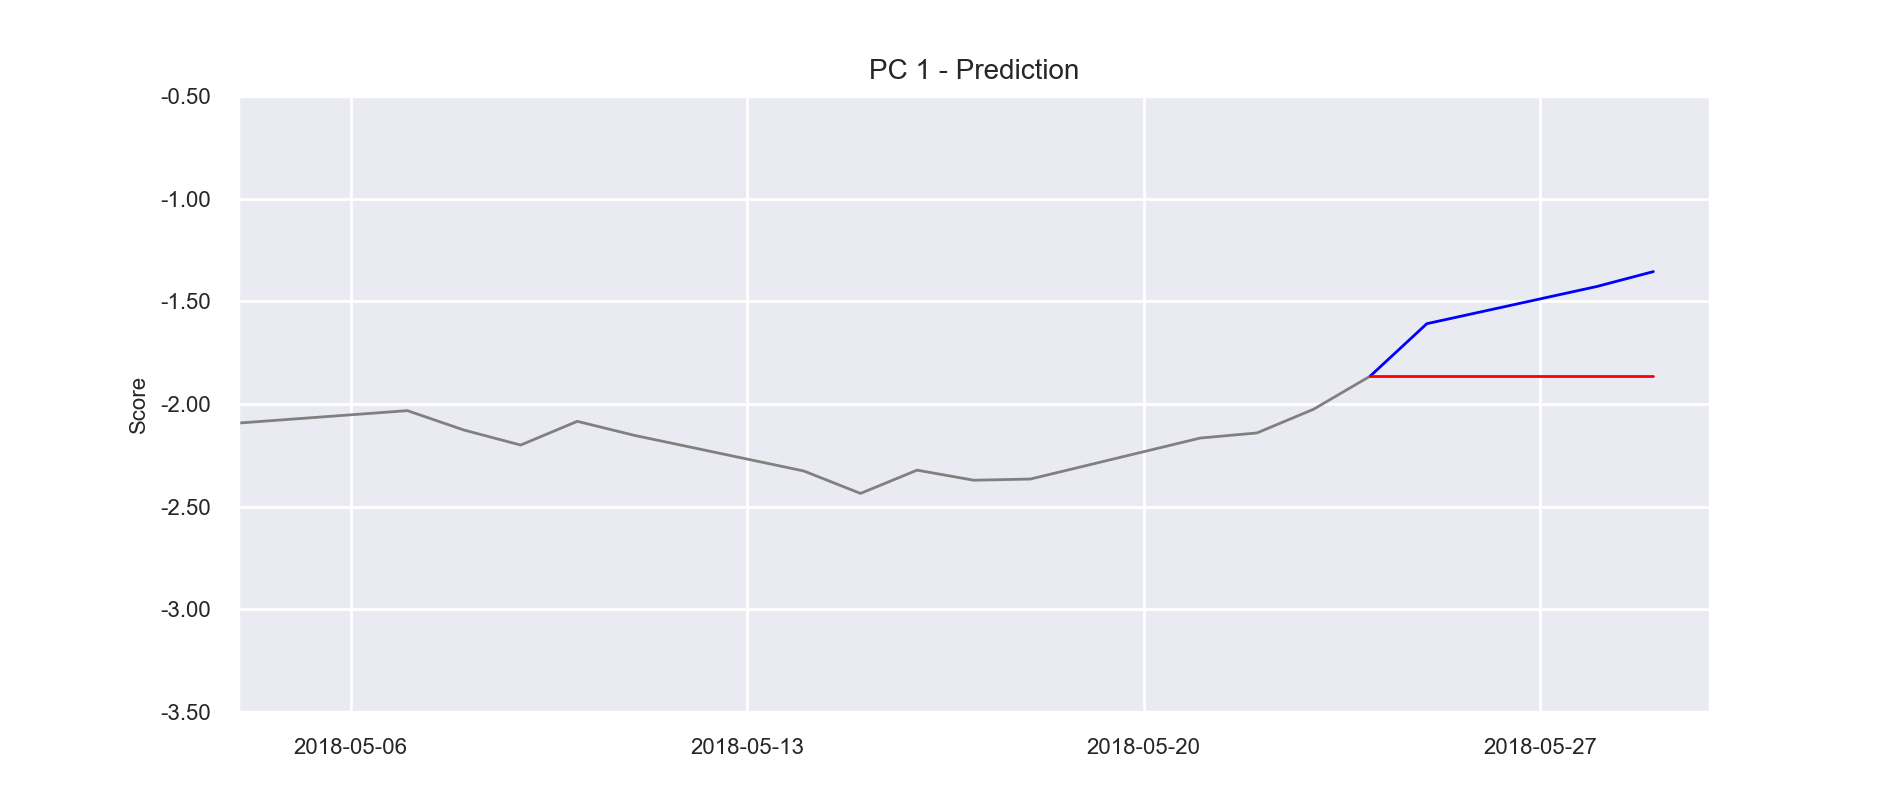

In [227]:
%matplotlib notebook

# (1) Creating figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9.5,4))
days = 15
horizon = 3


# (2) Prepare objects
y_hist = pc_scores_test["PC_1"].iloc[0:days].copy()
y_act  = pc_scores_test["PC_1"].iloc[days-1:days+horizon].copy()
y_pred = pc_scores_pred["PC_1"].iloc[days-1:days+horizon].copy()
y_pred[0] = y_hist[-1]

x_hist = y_hist.index
x_pred = y_act.index


# (3) Initialize objects
line_hist, = ax.plot(x_hist, y_hist, c="grey", linewidth=1, label = "historical")
line_act,  = ax.plot(x_pred, y_act,  c="blue", linewidth=1, label = "prediction")
line_pred, = ax.plot(x_pred, y_pred, c="red",  linewidth=1, label = "actual")
    

# (4) Fixed formatting
ax.set_title("PC 1 - Prediction", fontsize = 10)
ax.set_ylabel("Score", fontsize = 8)

ax.tick_params(axis="both", which="major", labelsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(days_fmt)
ax.xaxis.set_major_locator(days_loc)


# (4) Animation function
def animate(i):
    
    # (5.1) Update data
    y_hist = pc_scores_test["PC_1"].iloc[0+i:days+i].copy()
    y_act  = pc_scores_test["PC_1"].iloc[days-1+i:days+horizon+i].copy()
    y_pred = pc_scores_pred["PC_1"].iloc[days-1+i:days+horizon+i].copy()
    y_pred[0] = y_hist[-1]
    
    x_hist = y_hist.index
    x_pred = y_act.index

    line_hist.set_data(x_hist, y_hist)
    line_act.set_data(x_pred, y_act)    
    line_pred.set_data(x_pred, y_pred)

    # (5.2) Variable formatting
    ax.set_xlim(x_hist.min(), x_hist.max() + dt.timedelta(days=horizon+3))
    ax.set_ylim(np.floor(y_hist.min())-0.5, np.ceil(y_hist.max())+0.5)
    
    return line_hist
        

# (5) Animation iterating through the steps array
ani = FuncAnimation(fig, animate, np.arange(1,steps,1), interval=200, blit=True, repeat = False)
plt.show()

In [228]:
%matplotlib inline

979.py", line 42, in animate
    y_pred[0] = y_hist[-1]
  File "/opt/anaconda3/lib/python3.9/site-packages/pandas/core/series.py", line 1067, in __setitem__
    values[key] = value
IndexError: index 0 is out of bounds for axis 0 with size 0
